# Table of Content

<a name="outline"></a>

## Setup

- [A](#seca) External Imports
- [B](#secb) Internal Imports
- [C](#secc) Lazy Dictionary (Lazy Caching)
- [D](#secd) Configurations and Paths 
- [E](#sece) Patient Interface and Train/Val/Test Partitioning
- [F](#secf) General Utility Functions


## Evaluations

- [1](#sec1) Snooping/Selecting Best Models from the Validation Set
- [2](#sec2) Top-20 Detection Accuracy on MIMIC-III (Test Set)
- [3](#sec3) Top-20 Detection Accuracy on MIMIC-IV (Test Set)
- [4](#sec4) Relative AUC Performance on MIMIC-III (Test Set)
- [5](#sec5) Relative AUC Performance on MIMIC-IV (Test Set)
- [6](#sec6) Relative AUC Performance From MIMIC-III (Training Set) to MIMIC-IV (All)
- [7](#sec7) Relative AUC Performance From MIMIC-IV (Training Set) to MIMIC-III (All)

<a name="seca"></a>

### A External Imports [^](#outline)

In [1]:
import sys
import os
import glob
from collections import defaultdict

from IPython.display import display

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from upsetplot import from_contents, plot, UpSet, from_indicators


<a name="secb"></a>

### B Internal Imports [^](#outline)

In [2]:
sys.path.append('..')
HOME = os.environ.get('HOME')
from icenode.train_icenode_2lr import ICENODE
from icenode.train_icenode_uniform2lr import ICENODE as ICENODE_UNIFORM
from icenode.train_gram import GRAM
from icenode.train_retain import RETAIN
from icenode.metrics import codes_auc_pairwise_tests
from icenode.metrics import evaluation_table
from icenode.utils import write_params, load_config, load_params

%load_ext autoreload
%autoreload 2

/home/asem/anaconda3/envs/icenode/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


<a name="secc"></a>

### C Lazy Dictionary (Lazy Caching) [^](#outline)

In [3]:
class LazyDict(dict):
    def __getitem__(self, k):
        v = super().__getitem__(k)
        if callable(v):
            v = v()
            super().__setitem__(k, v)
        return v

    def get(self, k, default=None):
        if k in self:
            return self.__getitem__(k)
        return default

<a name="secd"></a>

### D Configurations and Paths [^](#outline)

In [4]:
mimic_dir = {
    'M3': f'{HOME}/GP/ehr-data/mimic3-transforms',
    'M4': f'{HOME}/GP/ehr-data/mimic4-transforms'
}

trained_dir = {
    'GM3': f'{HOME}/GP/ehr-data/icenode-m3-exp/train_config_v0.2.25_G_M3',
    'M3': f'{HOME}/GP/ehr-data/icenode-m3-exp/train_config_v0.2.25_M3',
    'M4': f'{HOME}/GP/ehr-data/icenode-m4-exp/train_config_v0.2.25_M4'
}

model_dir = {
    'ICE-NODE': 'icenode_2lr',
    'ICE-NODE_UNIFORM': 'icenode_uniform2lr',
    'GRU': 'gru',
    'RETAIN': 'retain'
}

model_cls = {
    'ICE-NODE': ICENODE,
    'ICE-NODE_UNIFORM': ICENODE_UNIFORM,
    'GRU': GRAM,
    'RETAIN': RETAIN
}   

clfs = list(model_dir.keys())

relative_auc_config = {
    'pvalue': 0.01, 
    'min_auc': 0.9
}

plt.rcParams["font.family"] = "Loma"#, "serif"


<a name="sece"></a>

### E Patient Interface and Train/Val/Test Patitioning [^](#outline)

In [5]:
def get_patient_interface(data_tag, clfs):
    interface_by_kind = LazyDict({
        'timestamped': lambda: ICENODE.create_patient_interface(mimic_dir[data_tag], data_tag),
        'sequential': lambda: GRAM.create_patient_interface(mimic_dir[data_tag], data_tag)
    })
    
    interface_kind = {
        'ICE-NODE':  'timestamped',
        'ICE-NODE_UNIFORM': 'timestamped',
        'GRU': 'sequential',
        'RETAIN': 'sequential'
    }

    return {clf: interface_by_kind[interface_kind[clf]] for clf in clfs}
    

m4_interface = get_patient_interface('M4', clfs)
m3_interface = get_patient_interface('M3', clfs)

m4_train_ids, m4_valid_ids, m4_test_ids = m4_interface[clfs[0]].random_splits(split1=0.7, split2=0.85, random_seed=42)
m3_train_ids, m3_valid_ids, m3_test_ids = m3_interface[clfs[0]].random_splits(split1=0.7, split2=0.85, random_seed=42)


In [6]:
m4_percentiles = m4_interface[clfs[0]].diag_flatccs_by_percentiles(20)
m3_percentiles = m3_interface[clfs[0]].diag_flatccs_by_percentiles(20)

m4_train_percentiles = m4_interface[clfs[0]].diag_flatccs_by_percentiles(20, m4_train_ids)
m3_train_percentiles = m3_interface[clfs[0]].diag_flatccs_by_percentiles(20, m3_train_ids)


<a name="secf"></a>

### F Utility Functions [^](#outline)

In [147]:

def performance_traces(data_tag, clfs):
    clfs_params_dir = trained_dir[data_tag]
    traces_df = []
    for clf in clfs:
        clf_dir = model_dir[clf]
        csv_files =  sorted(glob.glob(f'{clfs_params_dir}/{clf_dir}/*.csv', recursive=False))
        dfs = [pd.read_csv(csv_file, index_col=[0]) for csv_file in csv_files]
        df = pd.concat([df[["VAL"]].transpose() for df in dfs]).reset_index()
        df['comp'] = df[list(f'ACC-P{i}' for i in range(5))].prod(axis=1)
        df = df[['loss', 'accuracy', 'MICRO-AUC', 'comp']] 
        
        df = pd.melt(df.reset_index(), value_vars=df.columns, 
                          id_vars='index',
                          var_name='metric', 
                          value_name='value')
        df['loss'] = df['metric'] == 'loss'
        df['clf'] = clf
        traces_df.append(df)
    
    traces_df = pd.concat(traces_df)
    return traces_df

def get_trained_models(train_dir, clfs, criterion, comp):
    params = {}
    config = {}
    df = {}
    clfs_params_dir = trained_dir[train_dir]
    
    best_iter, best_val = [], []
    for clf in clfs:
        clf_dir = model_dir[clf]
        csv_files =  sorted(glob.glob(f'{clfs_params_dir}/{clf_dir}/*.csv', recursive=False))
        dfs = [pd.read_csv(csv_file, index_col=[0]) for csv_file in csv_files]
        
        if callable(criterion):
            max_i = comp(range(len(dfs)), key=lambda i: criterion(dfs[i].loc[:, 'VAL']))
            best_val.append(criterion(dfs[max_i].loc[:, 'VAL']))
        else:
            max_i = comp(range(len(dfs)), key=lambda i: dfs[i].loc[criterion, 'VAL'])
            best_val.append(dfs[max_i].loc[criterion, "VAL"])
        
        best_iter.append(max_i)
        df[clf] = dfs[max_i]        
        csv_file = csv_files[max_i]
        prefix = csv_file.split('_')
        prefix[-1] = 'params.pickle'
        params_file = '_'.join(prefix)
        params[clf] = load_params(params_file)
        config[clf] = load_config(f'{clfs_params_dir}/{clf_dir}/config.json')
        
    display(pd.DataFrame({'Clf': clfs, 'Best_i': best_iter, str(criterion): best_val}))
    return config, params, df


    
def eval_(model, ids):
    model, state = model
    return model.eval(state, ids)['diag_detectability']

def eval2_(model, ids):
    model, state = model
    return model.eval(state, ids)

def test_eval_table(dfs, metric):
    data = {}
    clfs = dfs.keys()
    for clf, df in dfs.items():
        data[clf] = df.loc[metric, "TST"].tolist()
    return pd.DataFrame(data=data, index=metric).transpose()

def get_model(clf, config, params, interface):
    model = model_cls[clf].create_model(config, interface, [], None)
    state = model.init_with_params(config, params)
    return model, state
        
def get_models(clfs, config, params, interface):
    return {clf: get_model(clf, config[clf], params[clf], interface[clf]) for clf in clfs}


def cross_predictor(clf, source_tag, target_tag):   
    if '/G' in clf:
        _m3_params = gm3_params
        _m3_config = gm3_config
        
        clf = clf.replace('/G','')
    else:
        _m3_params = m3_params
        _m3_config = m3_config

    if source_tag == 'M3':
        params = _m3_params[clf]
        config = _m3_config[clf]
    else:
        params = m4_params[clf]
        config = m4_config[clf]
        
    if target_tag == 'M3':
        target_interface = m3_interface[clf]
    else:
        target_interface = m4_interface[clf]
        
    
    return get_model(clf, config, params, target_interface)
            
    
def selected_auc_barplot(clfs, auctest_df, horizontal=False, rotate_ccs=True):
    auc_df = []

    for clf in clfs:
        comp_auc = auctest_df[f'AUC({clf})']
        comp_var = auctest_df[f'VAR[AUC({clf})]']
        comp_std = comp_var.apply(np.sqrt)
        comp_desc = auctest_df['DESC'].apply(lambda t: t if len(t) < 15 else t.replace(' ', '\n'))
        df = pd.DataFrame({'AUC': comp_auc, 'std': comp_std, 'CCS': comp_desc, 'Classifier': clf})
        auc_df.append(df)
    auc_df = pd.concat(auc_df)
    
    min_auc_tick = int(auc_df['AUC'].min() * 20)/20
    max_auc_tick = int(auc_df['AUC'].max() * 20 + 1)/20
    
    vals = auc_df.pivot(index='CCS', columns='Classifier', values='AUC')
    err = auc_df.pivot(index='CCS', columns='Classifier', values='std')
    
    if horizontal:
        # plot vals with yerr
        ax = vals.plot.barh(xerr=err, rot=0, figsize=(10, 10), width=0.7,
                            error_kw=dict(lw=5, capsize=8, capthick=5, ecolor='salmon'),
                            color=[ 'green', 'white', 'gray', 'skyblue'], edgecolor='black')
        plt.xlabel('AUC', fontsize=32)
        plt.xticks(fontsize=30)    
        plt.xlim(min_auc_tick, max_auc_tick)

        xstart, xend = ax.get_xlim()
        ax.xaxis.set_ticks(np.arange(xstart, xend+0.01, 0.05))

        plt.yticks(fontsize=24)

        plt.ylabel(None)
        ax.tick_params(bottom=True, left=False) 
        
        ax.xaxis.grid(color='gray', linestyle='dashed')
        ax.xaxis.set_zorder(3)


        
    else:
        # plot vals with yerr
        ax = vals.plot.bar(yerr=err, rot=0, figsize=(10, 10), width=0.7,
                            error_kw=dict(lw=5, capsize=8, capthick=5, ecolor='salmon'),
                            color=[ 'green', 'white', 'black', 'gray'], edgecolor='black')
        plt.ylabel('AUC', fontsize=32)
        plt.yticks(fontsize=24)    
        plt.ylim(min_auc_tick, max_auc_tick)

        ystart, yend = ax.get_ylim()
        ax.yaxis.set_ticks(np.arange(ystart, yend+0.01, 0.05))

        plt.xticks(fontsize=30, rotation=90 * rotate_ccs)

        plt.xlabel(None)
        ax.tick_params(bottom=False, left=True) 
        
        ax.yaxis.grid(color='gray', linestyle='dashed')
        ax.yaxis.set_zorder(3)
        
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(6)  # change width
        ax.spines[axis].set_color('red')    # change color


    _ = ax.legend(title='Classifier', loc='upper right', 
              fontsize=20, title_fontsize=32)
    # Add hatches
    bars = ax.patches
#     patterns =('.', 'x', 'O','o','/','-', '+','O','o','\\','\\\\')
    patterns =('', 'x', '','')
    hatches = [p for p in patterns for i in range(len(df))]
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
    

    return ax

def make_clf_paris(clfs):
    clfs_pairs = []
    for i in range(len(clfs)):
        for j in range(i + 1, len(clfs)):
            clfs_pairs.append((clfs[i], clfs[j]))
    return tuple(sorted(clfs_pairs))
    
def relative_performance_upset(auc_tests, selected_clfs, patient_interface, train_ids, pvalue, min_auc):
    flatccs_idx2code = {idx: code for code, idx in patient_interface.diag_flatccs_idx.items()}
    flatccs_frequency_train = patient_interface.diag_flatccs_frequency(train_ids)
    
    idx2desc = lambda i: patient_interface.dag.diag_flatccs_desc[flatccs_idx2code[i]]
    auc_tests['DESC'] = auc_tests['CODE_INDEX'].apply(idx2desc)
    
    # remove codes that no classifier has scored above 0.7
    accepted_aucs = auc_tests.loc[:,[f'AUC({clf})' for clf in selected_clfs]].max(axis=1) > min_auc
    print(f'{len(accepted_aucs)} codes predicted an AUC higher than {min_auc} by at least one model.')
    tests = auc_tests[accepted_aucs]
    tests = tests.fillna(1)
    test_cols = [col for col in tests.columns if col[:2] == 'P0']
    
    common_perf = tests[tests.loc[:,test_cols].min(axis=1) > pvalue]
    auc_sets = defaultdict(set)
    clfs = tuple(sorted(selected_clfs))
    auc_sets[clfs] = set(common_perf.CODE_INDEX)
    competing_tests = tests.drop(index=common_perf.index)

    clfs_pairs = make_clf_paris(clfs)

    for index, row in competing_tests.iterrows():
        max_auc_clf = max(clfs, key=lambda clf: row[f'AUC({clf})'])
        insignificant_diff = {(clf1, clf2): f'P0(AUC_{clf1}==AUC_{clf2})' for (clf1, clf2) in clfs_pairs \
                          if max_auc_clf in (clf1, clf2) and row[f'P0(AUC_{clf1}==AUC_{clf2})'] > pvalue}

        if len(insignificant_diff) == 0:
            auc_sets[max_auc_clf].add(int(row['CODE_INDEX']))
        else:
            for (clf1, clf2), test_col in insignificant_diff.items():
                auc_sets[(clf1, clf2)].add(int(row['CODE_INDEX']))            
            
    # Prepare for using Upset plot -> Set Layout (passed to `from_contents`)
    content_sets = {}
    for clf in clfs:
        content_sets[clf] = auc_sets[clf] | auc_sets[clfs]
        for clf1, clf2 in clfs_pairs:
            if clf in (clf1, clf2):
                content_sets[clf].update(auc_sets[(clf1, clf2)])
    
    # Prepare for using Upset plot -> DataFrame Layout (passed to `from_indicators`)
    code_index = tests.CODE_INDEX.tolist()
    competence_assignments = {}
    for clf in clfs:
        competence_assignments[clf] = [c in content_sets[clf] for c in code_index]
    indicator_df = pd.DataFrame(competence_assignments, index=code_index)
    
    # Descriptive statistics for each code.    
    avg_aucs, n_codes = [], []
    for c in code_index:
        competent_clfs = [clf for clf in clfs if indicator_df.loc[c, clf]]
        avg_auc = tests.loc[c, list(f'AUC({clf})' for clf in competent_clfs)].mean()
        avg_aucs.append(avg_auc)
        n_codes.append(flatccs_frequency_train[c])
    data = pd.DataFrame({'Avg. AUC': avg_aucs, '#positive cases (train)': n_codes}, index=code_index)    
    return content_sets, indicator_df, data, common_perf, competing_tests


<a name="sec1"></a>

## 1 Snooping/Selecting Best Models from the Validation Set [^](#outline)

In [8]:
# Classifiers with Linear Embeddings
clfs = (
    'ICE-NODE', 
    'ICE-NODE_UNIFORM',
    'GRU',
    'RETAIN'
)


# Classifiers with GRAM Embeddings
clfsG = (
    'ICE-NODE', 
    'ICE-NODE_UNIFORM',
    'GRU'
)

In [30]:
m4_traces = performance_traces('M4', clfs)
gm3_traces =  performance_traces('GM3', clfsG)
m3_traces = performance_traces('M3', clfs)

plt_ctx = lambda : sns.plotting_context("poster", font_scale=2, rc={"lines.linewidth": 2.5,  'grid.linestyle': '--'})


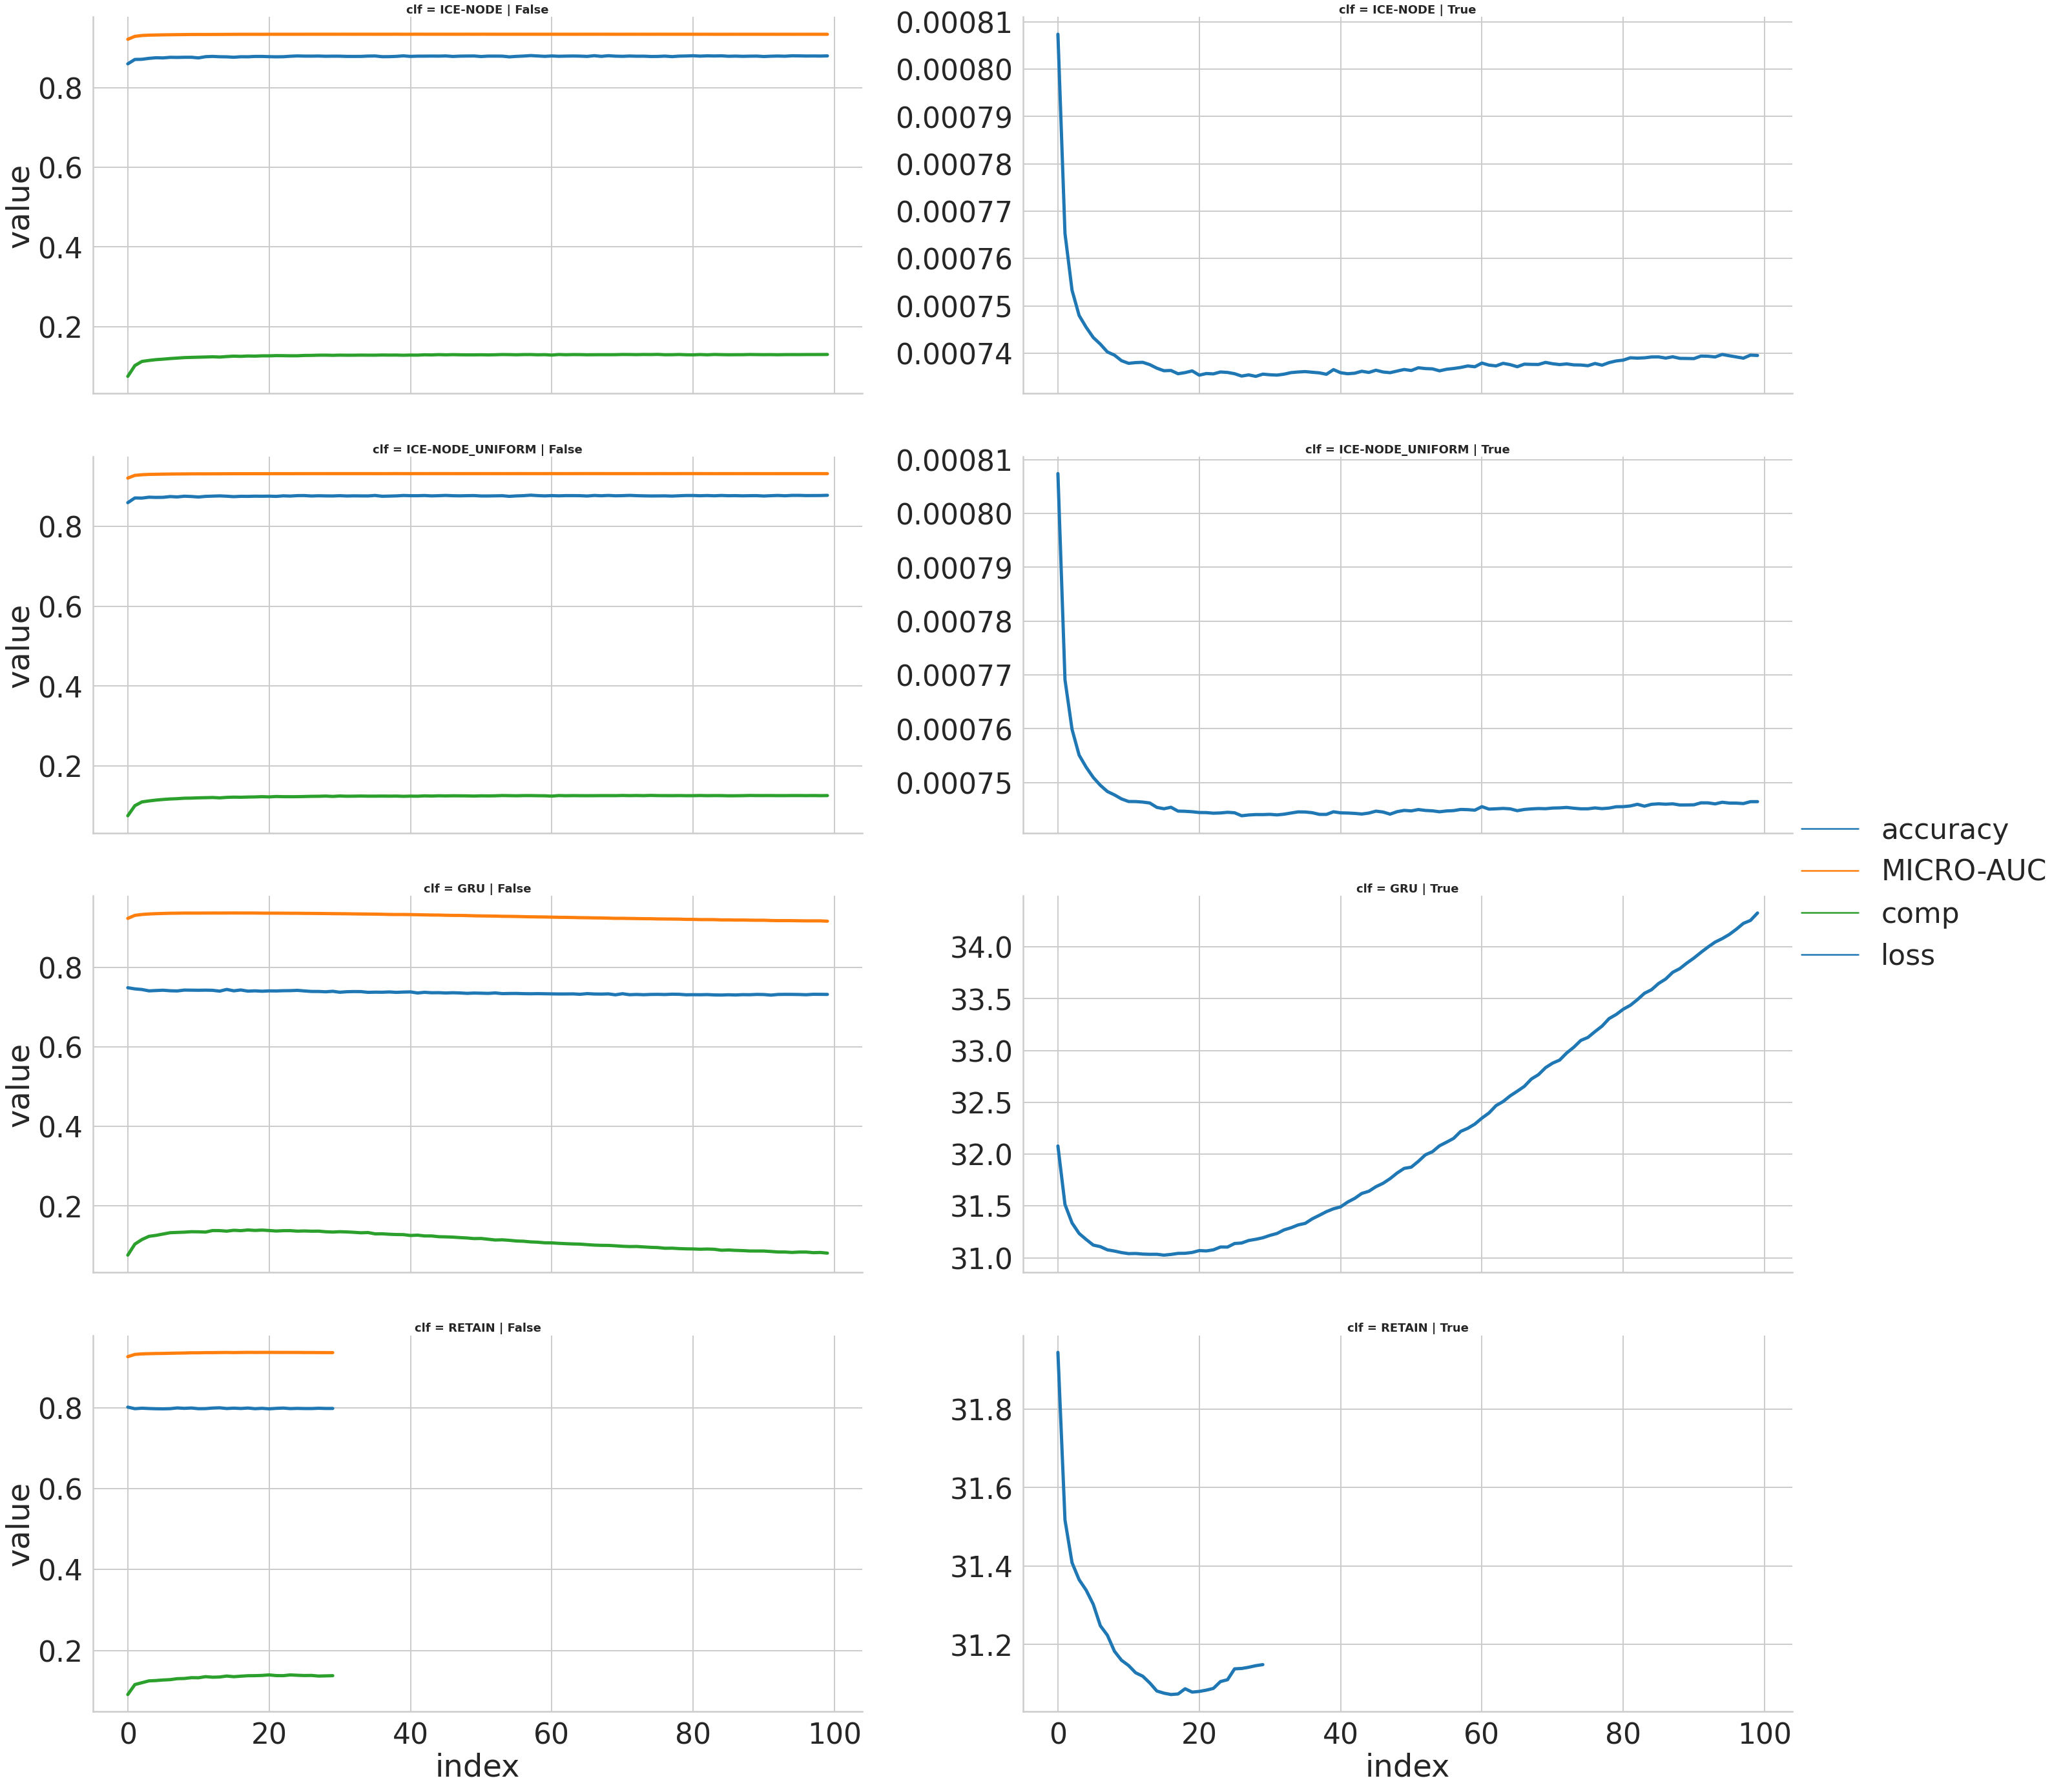

In [33]:
with sns.axes_style("whitegrid"), plt_ctx():
    g = sns.FacetGrid(data=m4_traces, row='clf', col='loss',  height=10, aspect=2, sharey=False, despine=True)
    g.map_dataframe(sns.lineplot, 'index', 'value', 'metric', **dict(linewidth=5))
    g.set_titles(col_template="{col_name}", fontweight='bold', size=18)
    g.add_legend()

    current_figure = plt.gcf()
    current_figure.savefig(f"M4_performance_trace.pdf")

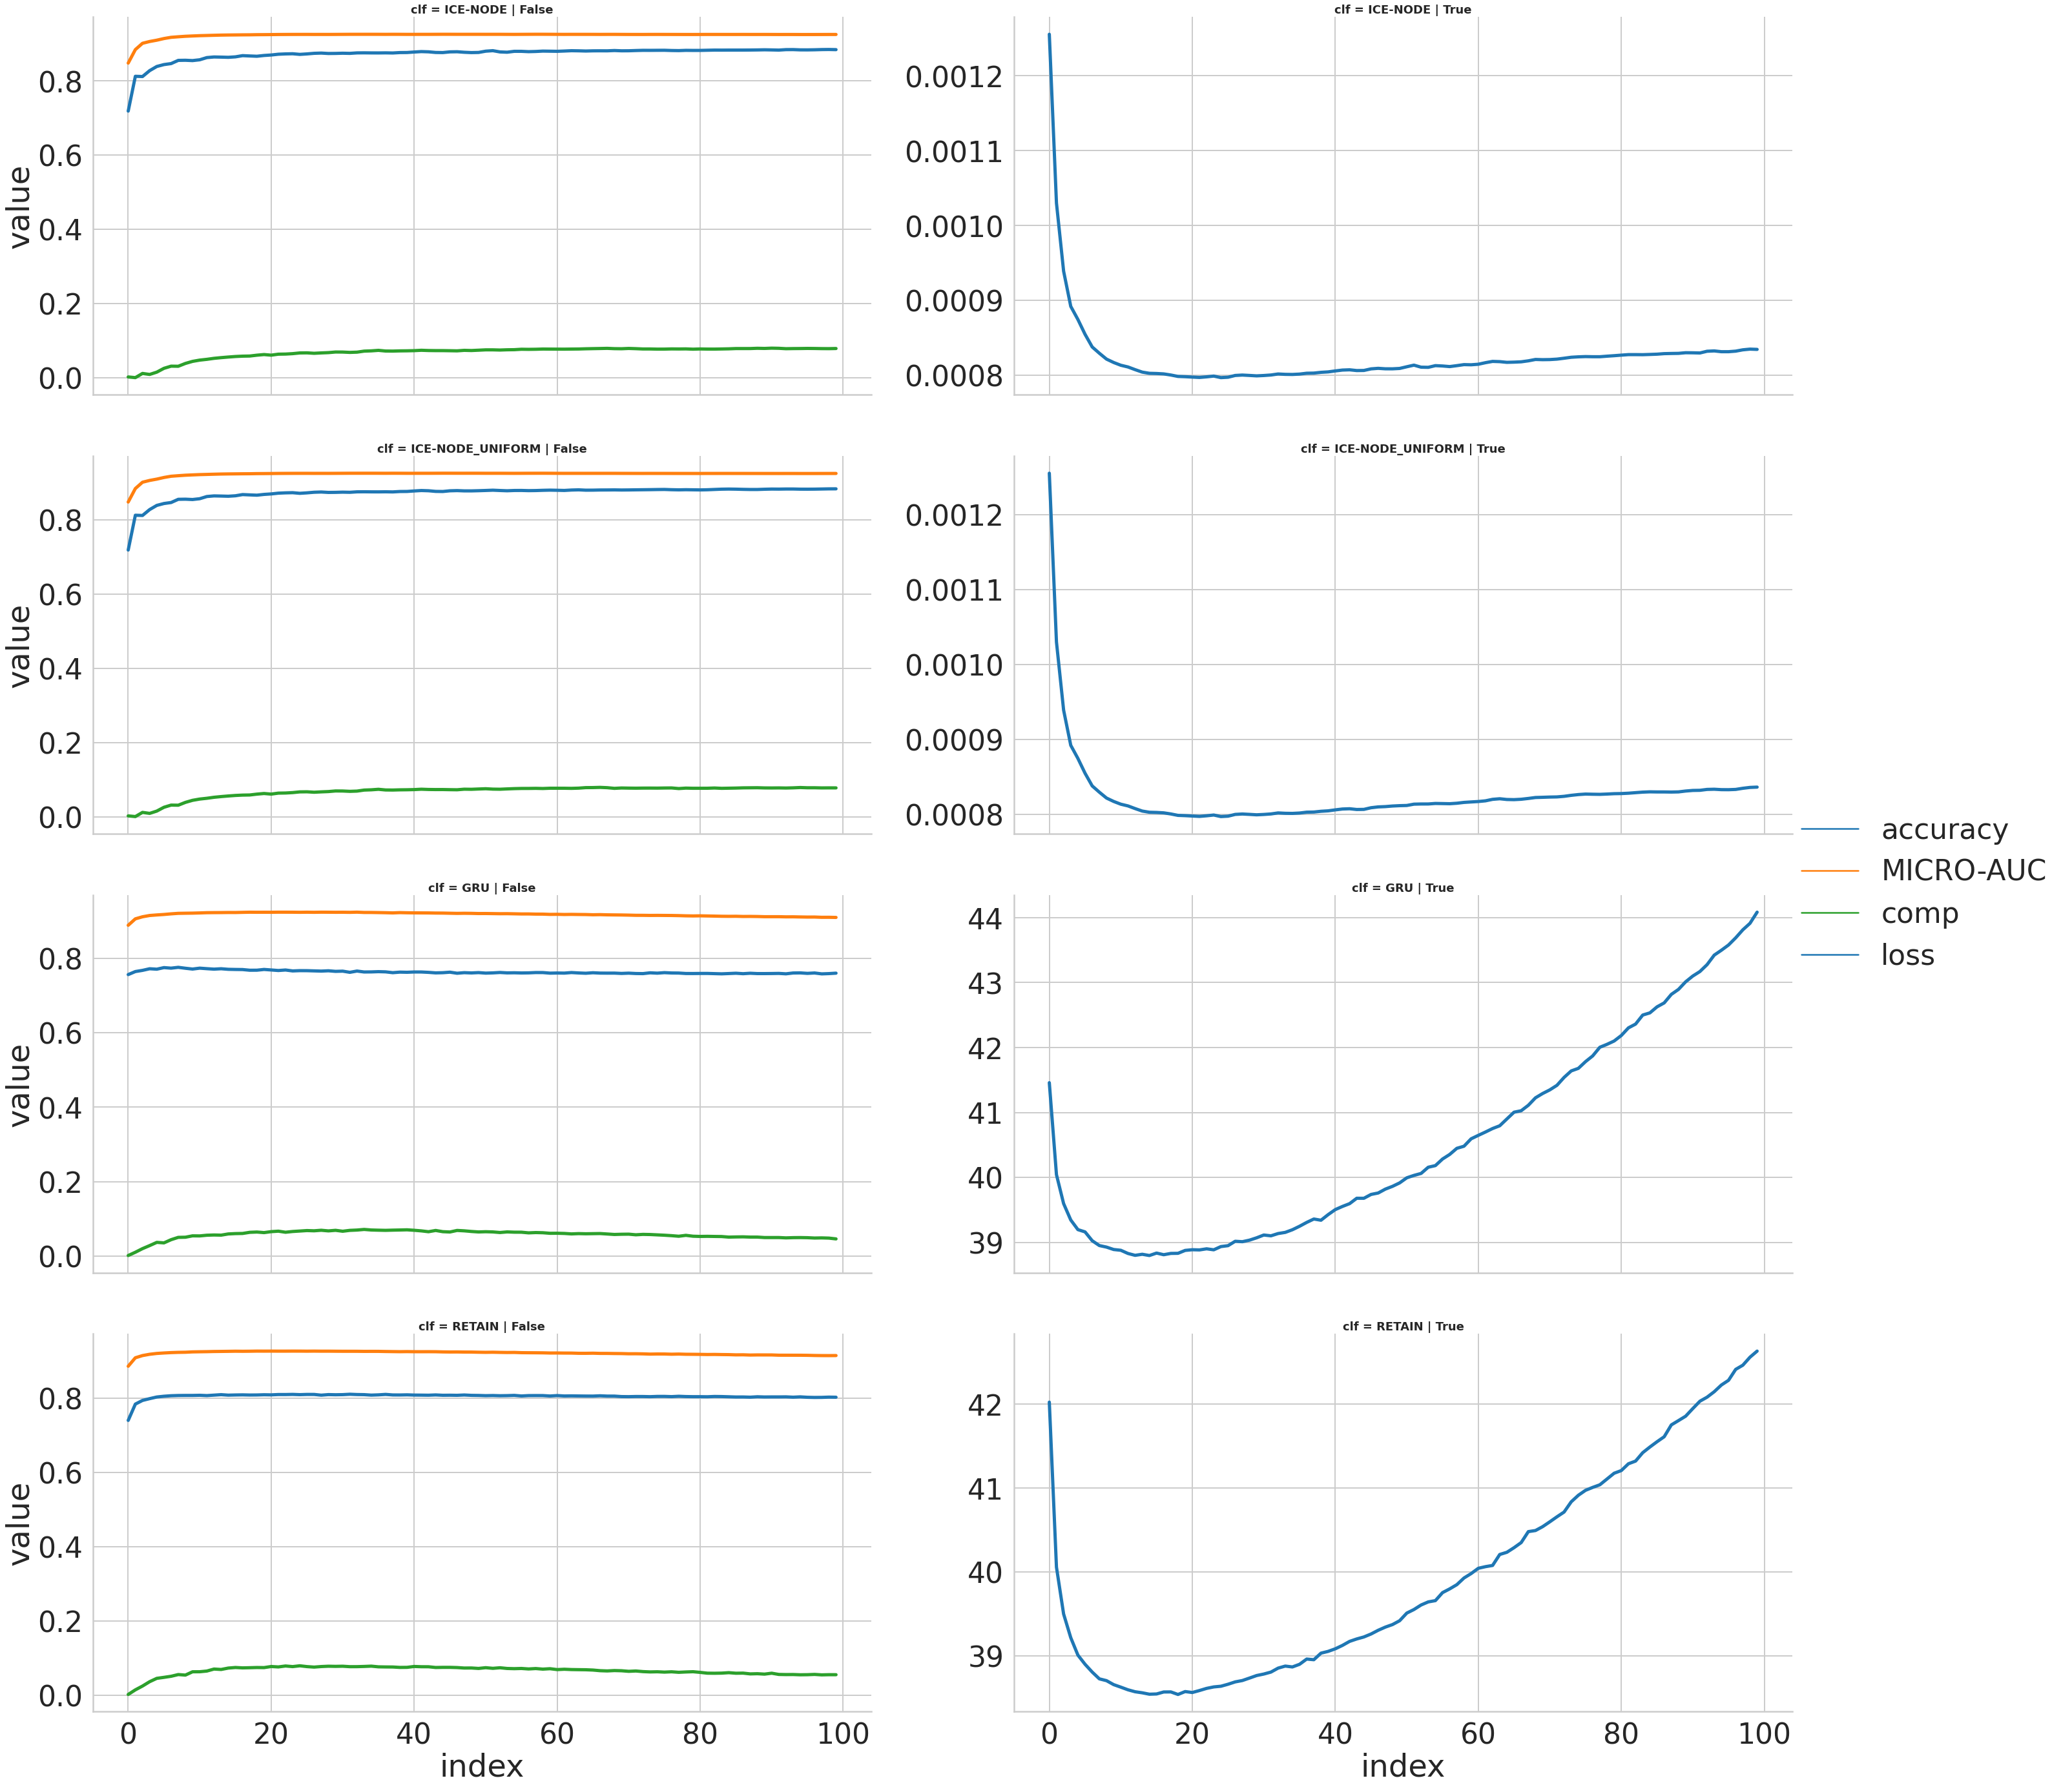

In [34]:
with sns.axes_style("whitegrid"), plt_ctx():
    g = sns.FacetGrid(data=m3_traces, row='clf', col='loss',  height=10, aspect=2, sharey=False, despine=True)
    g.map_dataframe(sns.lineplot, 'index', 'value', 'metric', **dict(linewidth=5))
    g.set_titles(col_template="{col_name}", fontweight='bold', size=18)
    g.add_legend()
    
    current_figure = plt.gcf()
    current_figure.savefig(f"M3_performance_trace.pdf")

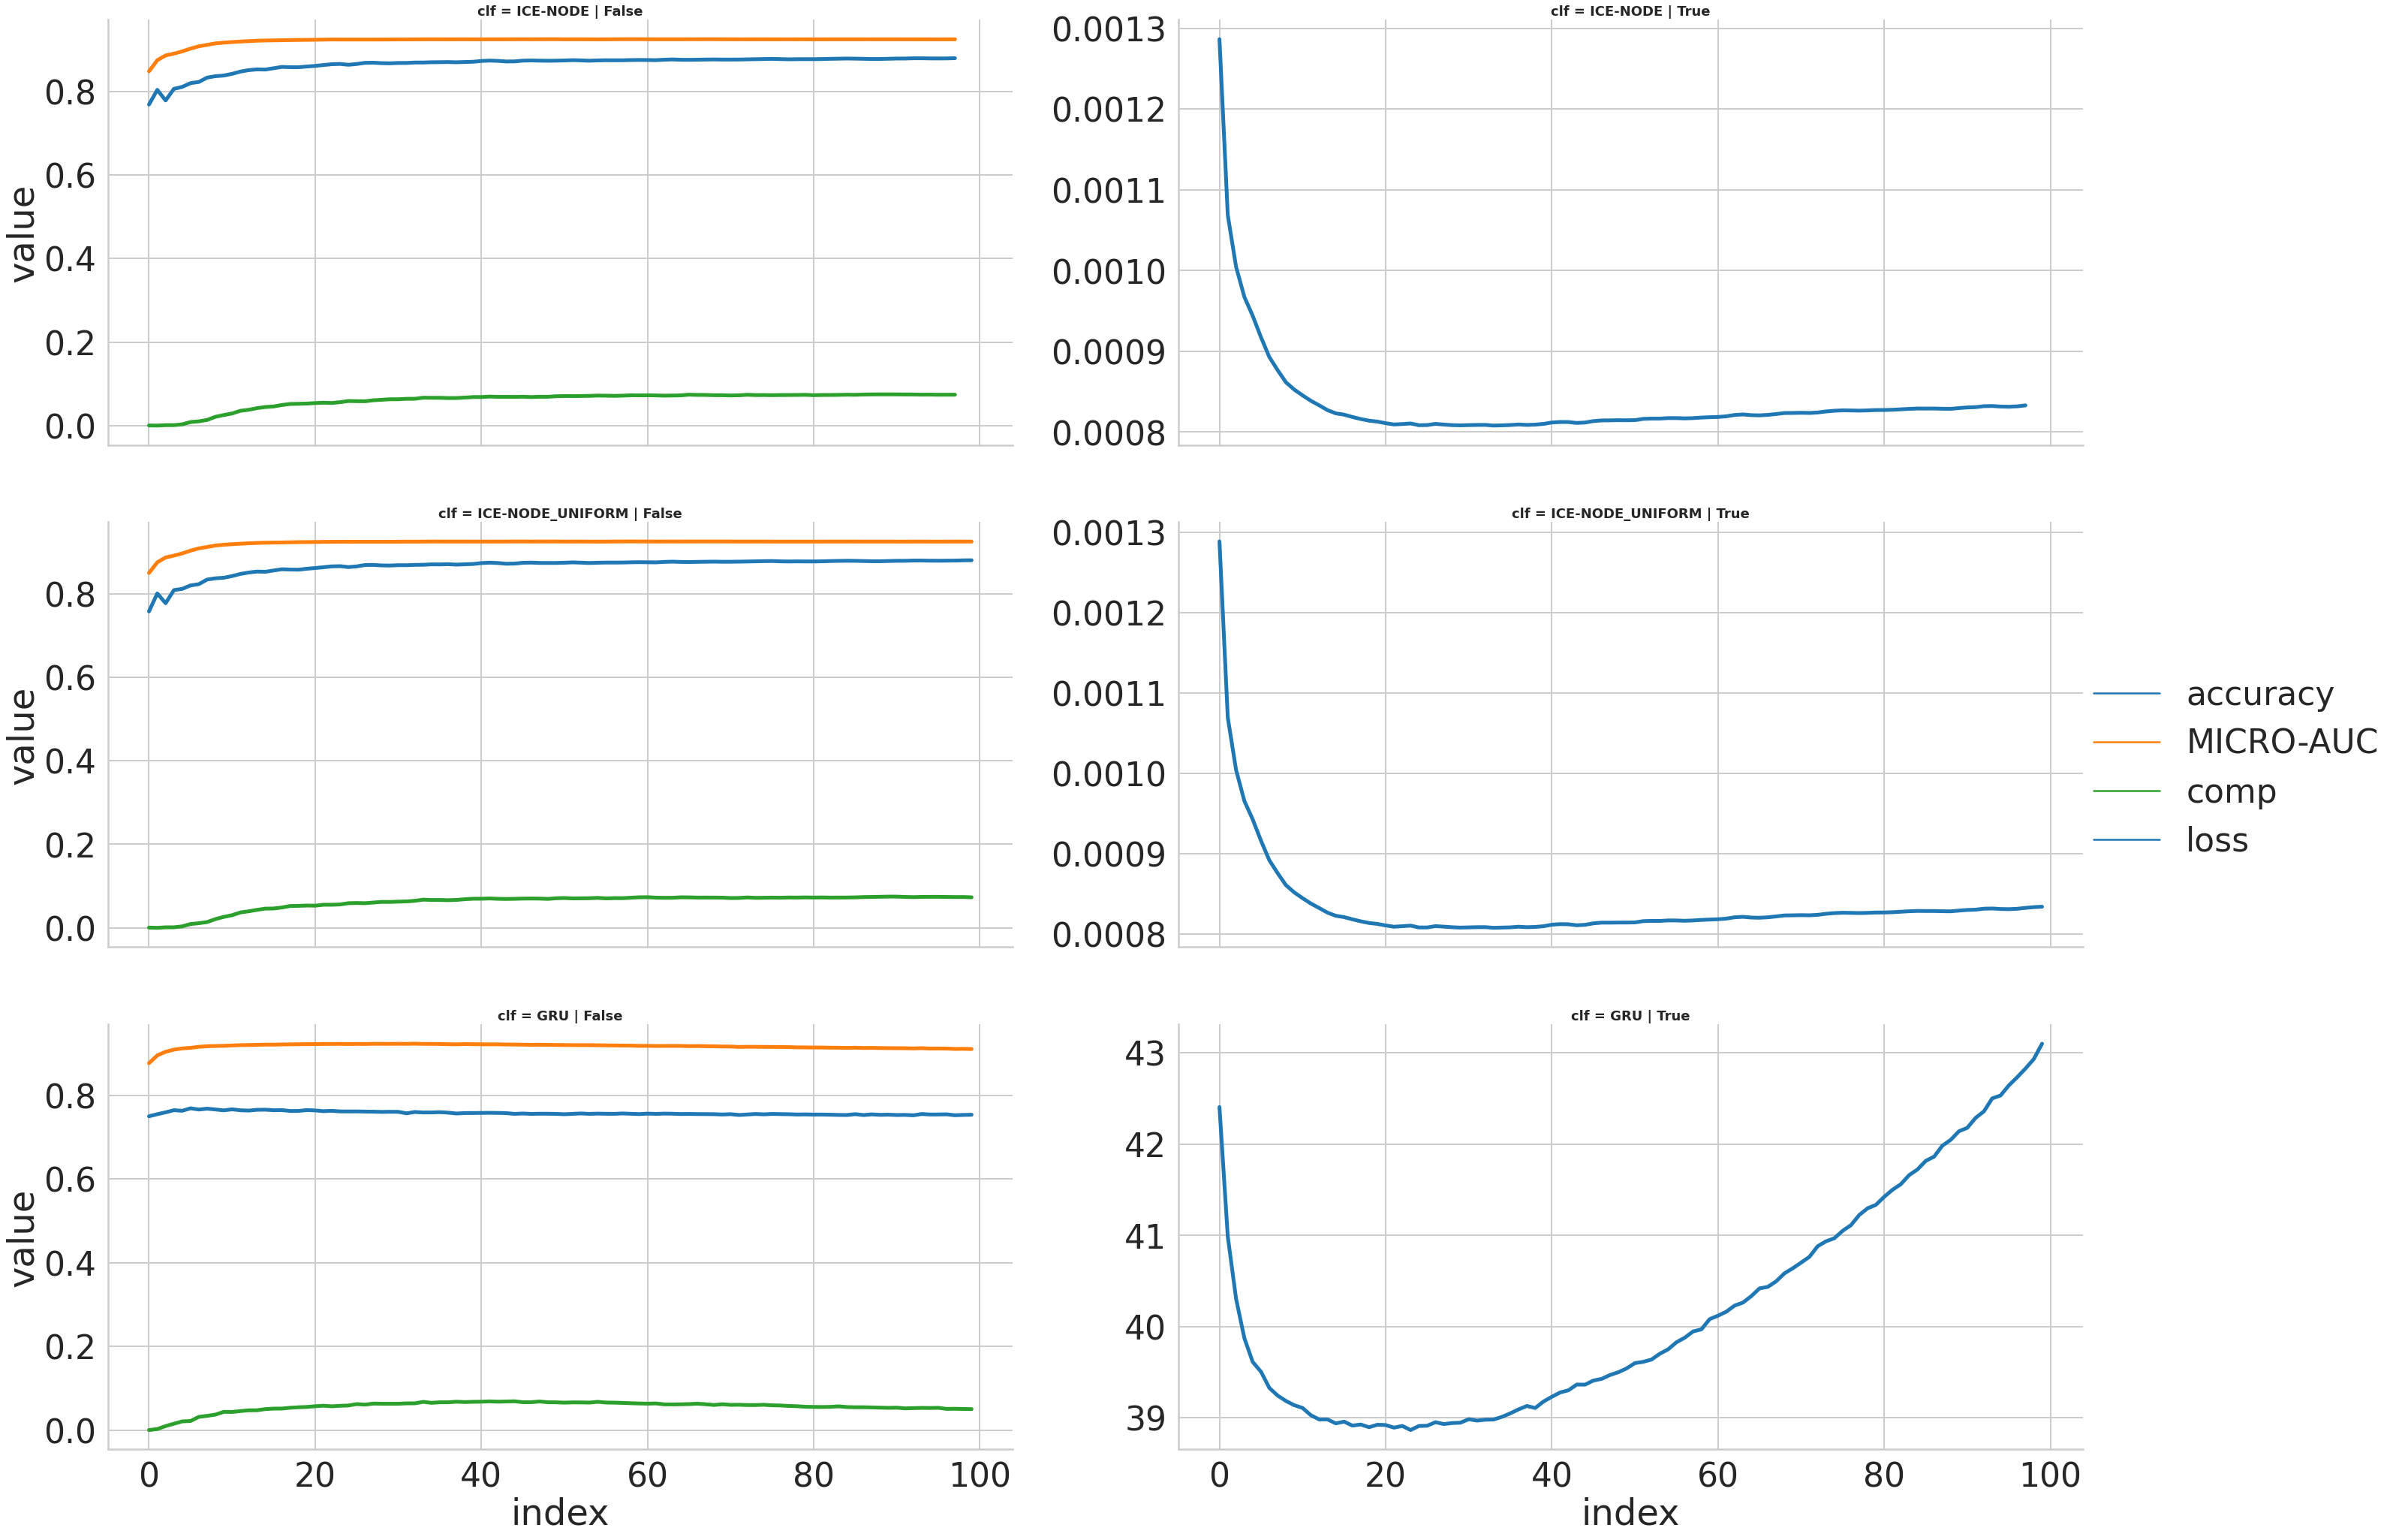

In [35]:
with sns.axes_style("whitegrid"), plt_ctx():
    g = sns.FacetGrid(data=gm3_traces, row='clf', col='loss',  height=10, aspect=2, sharey=False, despine=True)
    g.map_dataframe(sns.lineplot, 'index', 'value', 'metric', **dict(linewidth=5))
    g.set_titles(col_template="{col_name}", fontweight='bold', size=18)
    g.add_legend()
    
    current_figure = plt.gcf()
    current_figure.savefig(f"GM3_performance_trace.pdf")

In [13]:


print('> Models trained on MIMIC-IV')

m4_config_uAUC, m4_params_uAUC, m4_df_uAUC = get_trained_models('M4', clfs, 'MICRO-AUC', comp=max)

print('> Models trained on MIMIC-III')

m3_config_uAUC, m3_params_uAUC, m3_df_uAUC = get_trained_models('M3', clfs, 'MICRO-AUC', comp=max)

print('> Models (GRAM) trained on MIMIC-III')

m3_config_uAUCG, m3_params_uAUCG, m3_df_uAUCG = get_trained_models('GM3', clfsG, 'MICRO-AUC', comp=max)


> Models trained on MIMIC-IV


Clf  Best_i  MICRO-AUC
0          ICE-NODE      38   0.933961
1  ICE-NODE_UNIFORM      66   0.932462
2               GRU      15   0.936528
3            RETAIN      17   0.936482

> Models trained on MIMIC-III


Clf  Best_i  MICRO-AUC
0          ICE-NODE      57   0.925790
1  ICE-NODE_UNIFORM      44   0.925757
2               GRU      32   0.923570
3            RETAIN      20   0.927307

> Models (GRAM) trained on MIMIC-III


Clf  Best_i  MICRO-AUC
0          ICE-NODE      58   0.924722
1  ICE-NODE_UNIFORM      58   0.924760
2               GRU      32   0.923149

In [14]:
print('> Models trained on MIMIC-IV')

m4_config_loss, m4_params_loss, m4_df_loss = get_trained_models('M4', clfs, 'loss', comp=min)

print('> Models trained on MIMIC-III')

m3_config_loss, m3_params_loss, m3_df_loss = get_trained_models('M3', clfs, 'loss', comp=min)

print('> Models (GRAM) trained on MIMIC-III')

m3_config_lossG, m3_params_lossG, m3_df_lossG = get_trained_models('GM3', clfsG, 'loss', comp=min)


> Models trained on MIMIC-IV


Clf  Best_i       loss
0          ICE-NODE      28   0.000735
1  ICE-NODE_UNIFORM      26   0.000744
2               GRU      15  31.025291
3            RETAIN      16  31.072317

> Models trained on MIMIC-III


Clf  Best_i       loss
0          ICE-NODE      24   0.000797
1  ICE-NODE_UNIFORM      24   0.000797
2               GRU      14  38.797390
3            RETAIN      18  38.536705

> Models (GRAM) trained on MIMIC-III


Clf  Best_i       loss
0          ICE-NODE      33   0.000808
1  ICE-NODE_UNIFORM      33   0.000808
2               GRU      23  38.865055

In [15]:
def combine_acc(row):
    return 1 / (1 / row.loc[list(f'ACC-P{i}' for i in range(5))]).sum()

print('> Models trained on MIMIC-IV')

m4_config_comb, m4_params_comb, m4_df_comb = get_trained_models('M4', clfs,
                                                                combine_acc, 
                                                                comp=max)

print('> Models trained on MIMIC-III')

m3_config_comb, m3_params_comb, m3_df_comb = get_trained_models('M3', clfs, combine_acc, comp=max)

print('> Models (GRAM) trained on MIMIC-III')

m3_config_combG, m3_params_combG, m3_df_combG = get_trained_models('GM3', clfsG, combine_acc, comp=max)


> Models trained on MIMIC-IV


Clf  Best_i  <function combine_acc at 0x7f06027ac160>
0          ICE-NODE      88                                  0.126702
1  ICE-NODE_UNIFORM      88                                  0.125716
2               GRU      19                                  0.127814
3            RETAIN      23                                  0.127869

> Models trained on MIMIC-III


Clf  Best_i  <function combine_acc at 0x7f06027ac160>
0          ICE-NODE      90                                  0.109711
1  ICE-NODE_UNIFORM      94                                  0.109345
2               GRU      39                                  0.107409
3            RETAIN      40                                  0.109896

> Models (GRAM) trained on MIMIC-III


Clf  Best_i  <function combine_acc at 0x7f06027ac160>
0          ICE-NODE      88                                  0.107542
1  ICE-NODE_UNIFORM      90                                  0.107439
2               GRU      44                                  0.106158

In [16]:
m4_models_uAUC = get_models(clfs, m4_config_uAUC, m4_params_uAUC, m4_interface)
m3_models_uAUC = get_models(clfs, m3_config_uAUC, m3_params_uAUC, m3_interface)
m3_models_uAUCG = get_models(clfsG, m3_config_uAUCG, m3_params_uAUCG, m3_interface)

In [17]:
m4_models_loss = get_models(clfs, m4_config_loss, m4_params_loss, m4_interface)
m3_models_loss = get_models(clfs, m3_config_loss, m3_params_loss, m3_interface)
m3_models_lossG = get_models(clfsG, m3_config_lossG, m3_params_lossG, m3_interface)

In [18]:
m4_models_comb = get_models(clfs, m4_config_comb, m4_params_comb, m4_interface)
m3_models_comb = get_models(clfs, m3_config_comb, m3_params_comb, m3_interface)
m3_models_combG = get_models(clfsG, m3_config_combG, m3_params_combG, m3_interface)

### Snooping on MIMIC-III Validation Set

In [19]:
m3_val_res_uAUC = {clf: eval_(model, m3_valid_ids) for clf, model in m3_models_uAUC.items()} 
m3_val_res_comb = {clf: eval_(model, m3_valid_ids) for clf, model in m3_models_comb.items()} 
m3_val_res_loss = {clf: eval_(model, m3_valid_ids) for clf, model in m3_models_loss.items()} 

m3_val_res_all = {
    **{f'{clf}_uAUC': res for clf, res in m3_val_res_uAUC.items()},
    **{f'{clf}_comb': res for clf, res in m3_val_res_comb.items()},
    **{f'{clf}_loss': res for clf, res in m3_val_res_loss.items()}
}
m3_val_auctests_all = codes_auc_pairwise_tests(m3_val_res_all, fast=True)

  0%|                                                   | 0/242 [00:00<?, ?it/s]/home/asem/GP/ICENODE/analysis/../icenode/delong.py:203: RuntimeWarning: invalid value encountered in true_divide
  z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
100%|█████████████████████████████████████████| 242/242 [00:35<00:00,  6.89it/s]


184 codes predicted an AUC higher than 0.9 by at least one model.


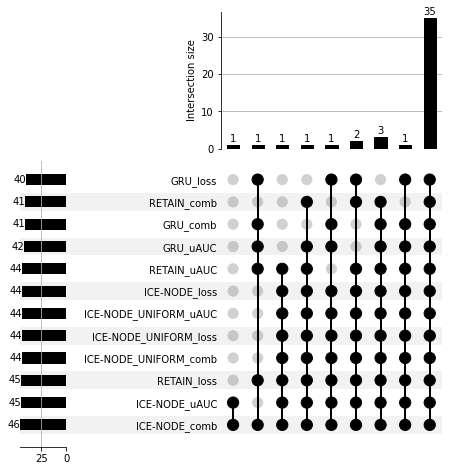

In [37]:

selected_clfs = tuple(sorted(m3_val_res_all.keys()))
content_set, indicator_df, data, common_codes, dichotomous_codes = relative_performance_upset(m3_val_auctests_all, selected_clfs, 
                                                                                              m3_interface[clfs[0]],
                                                                                              m3_train_ids,
                                                                                              **relative_auc_config)
upset_format = from_indicators(indicator_df, data=data)
upset_object = UpSet(upset_format, subset_size='count', show_counts=True)

upset_object.plot()
plt.show()

### Snooping on MIMIC-IV Validation Set

In [21]:
m4_val_res_uAUC = {clf: eval_(model, m4_valid_ids) for clf, model in m4_models_uAUC.items()} 
m4_val_res_comb = {clf: eval_(model, m4_valid_ids) for clf, model in m4_models_comb.items()} 
m4_val_res_loss = {clf: eval_(model, m4_valid_ids) for clf, model in m4_models_loss.items()} 

m4_val_res_all = {
    **{f'{clf}_uAUC': res for clf, res in m4_val_res_uAUC.items()},
    **{f'{clf}_comb': res for clf, res in m4_val_res_comb.items()},
    **{f'{clf}_loss': res for clf, res in m4_val_res_loss.items()}
}
m4_val_auctests_all = codes_auc_pairwise_tests(m4_val_res_all, fast=True)

  0%|                                                   | 0/242 [00:00<?, ?it/s]/home/asem/GP/ICENODE/analysis/../icenode/delong.py:203: RuntimeWarning: invalid value encountered in true_divide
  z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
100%|█████████████████████████████████████████| 242/242 [19:31<00:00,  4.84s/it]


237 codes predicted an AUC higher than 0.9 by at least one model.


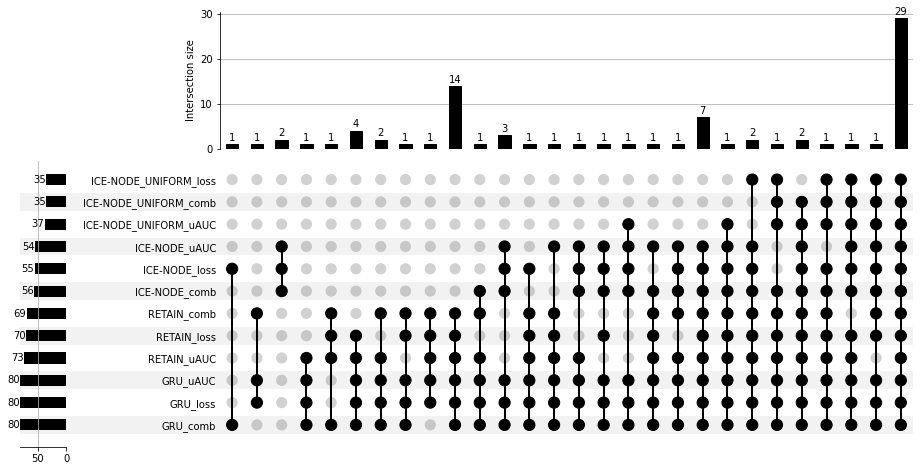

In [38]:
selected_clfs = tuple(sorted(m4_val_res_all.keys()))
content_set, indicator_df, data, common_codes, dichotomous_codes = relative_performance_upset(m4_val_auctests_all,
                                                                                              selected_clfs, 
                                                                                              m4_interface[clfs[0]],
                                                                                              m4_train_ids,
                                                                                              **relative_auc_config)
upset_format = from_indicators(indicator_df, data=data)
upset_object = UpSet(upset_format, subset_size='count', show_counts=True)

upset_object.plot()
plt.show()

### Snooping Conclusion

In the cells above, we evaluate the model competency by the number of codes
predicted competently compared to the other models.
It is realized that for `GRU`, `RETAIN`, and `ICENODE_UNIFORM`, the competency is maximized by picking the
model with minimum validation loss throughout the training iterations.
However, `ICENODE` competency is maximized by picking the model with maximum average validation AUC throughout the training iterations. Therefore, subsequent evaluations will consider only the most competent models on the validation set, as we select in the next cell.

In [62]:
m4_config = {}
m4_params = {}
m4_eval = {}

m3_config = {}
m3_params = {}
m3_eval = {}

gm3_config = {}
gm3_params = {}
gm3_eval = {}

selection_dicts = (m4_config, m4_params, m4_eval, 
                   m3_config, m3_params, m3_eval, 
                   gm3_config, gm3_params, gm3_eval)

uAUC_dicts = (m4_config_uAUC, m4_params_uAUC, m4_df_uAUC,
              m3_config_uAUC, m3_params_uAUC, m3_df_uAUC,
              m3_config_uAUCG, m3_params_uAUCG, m3_df_uAUCG)

comb_dicts = (m4_config_comb, m4_params_comb, m4_df_comb,
              m3_config_comb, m3_params_comb, m3_df_comb,
              m3_config_combG, m3_params_combG, m3_df_combG)


loss_dicts = (m4_config_loss, m4_params_loss, m4_df_loss,
              m3_config_loss, m3_params_loss, m3_df_loss,
              m3_config_lossG, m3_params_lossG, m3_df_lossG)

for clf in ('GRU', 'RETAIN', 'ICE-NODE', 'ICE-NODE_UNIFORM'):
#     best_dicts = maxauc_dicts
#     if clf == 'ICE-NODE':

#     else:
#     best_dicts = minloss_dicts
        
    for dict_a, dict_b in zip(selection_dicts, loss_dicts):
        if clf in dict_b:
            dict_a[clf] = dict_b[clf]

<a name="sec2"></a>

## 2 Top-20 Detection Accuracy on MIMIC-III (Test Set) [^](#outline)

In [63]:


def styled_df(df):  
    import numpy as np
    pd.set_option('precision', 3)
    def highlight_max(s, props=''):
        return np.where(s == np.nanmax(s.values), props, '')
    
    s_df = df.style
    s_df = s_df.apply(highlight_max, props='bfseries: ;color:white;background-color:darkblue', axis=0)
    texttt = [{'selector': 'th', 'props': 'font-family: monospace;'}]

    latex_str = s_df.to_latex(convert_css=True)
    for clf in df.index.tolist():
        latex_str = latex_str.replace(clf, f'\\texttt{{{clf}}}', 1)
    latex_str = latex_str.replace('_', '\\_')
    return s_df, latex_str

In [64]:
# Pick the best models results from max_auc and min_loss snapshots on the validation data.



df_acc20_dict = {
    **{clf: m3_eval[clf] for clf in ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')},
    **{f'{clf}/G': gm3_eval[clf] for clf in ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU')},
}

df_acc20 = test_eval_table(df_acc20_dict, list(f'ACC-P{i}' for i in range(5)))
df_acc20 = df_acc20.apply(lambda x: round(x, 3))
df_acc20.to_csv(f'acc20_mimic3.csv')

s_df, ltx_s = styled_df(df_acc20)
display(s_df)
print(ltx_s)

\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & 0.230 & 0.496 & \color{white} {\cellcolor{darkblue}} 0.691 & 0.859 & 0.958 \\
\texttt{ICE-NODE\_UNIFORM} & 0.230 & 0.496 & \color{white} {\cellcolor{darkblue}} 0.691 & 0.859 & 0.958 \\
\texttt{GRU} & 0.212 & 0.481 & 0.673 & 0.870 & 0.964 \\
\texttt{RETAIN} & \color{white} {\cellcolor{darkblue}} 0.238 & \color{white} {\cellcolor{darkblue}} 0.499 & 0.690 & \color{white} {\cellcolor{darkblue}} 0.877 & \color{white} {\cellcolor{darkblue}} 0.973 \\
\texttt{ICE-NODE/G} & 0.221 & 0.493 & 0.671 & 0.870 & 0.952 \\
\texttt{ICE-NODE\_UNIFORM/G} & 0.217 & 0.493 & 0.674 & 0.867 & 0.955 \\
\texttt{GRU/G} & 0.224 & 0.483 & 0.677 & 0.863 & 0.959 \\
\end{tabular}



<a name="sec3"></a>

## 3 Top-20 Detection Accuracy on MIMIC-IV (Test Set) [^](#outline)

In [65]:
# Pick the best models results from max_auc and min_loss snapshots on the validation data.
df_acc20 = {
    clf: m4_eval[clf] for clf in ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')
}

df_acc20 = test_eval_table(df_acc20, list(f'ACC-P{i}' for i in range(5)))
df_acc20 = df_acc20.apply(lambda x: round(x, 3))
df_acc20.to_csv(f'acc20_mimic4.csv')

s_df, ltx_s = styled_df(df_acc20)
display(s_df)
print(ltx_s)

\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & \color{white} {\cellcolor{darkblue}} 0.406 & 0.549 & 0.697 & 0.873 & 0.943 \\
\texttt{ICE-NODE\_UNIFORM} & 0.401 & 0.540 & 0.691 & 0.870 & 0.946 \\
\texttt{GRU} & 0.396 & \color{white} {\cellcolor{darkblue}} 0.558 & \color{white} {\cellcolor{darkblue}} 0.733 & 0.896 & 0.950 \\
\texttt{RETAIN} & 0.393 & 0.541 & 0.725 & \color{white} {\cellcolor{darkblue}} 0.903 & \color{white} {\cellcolor{darkblue}} 0.962 \\
\end{tabular}



<a name="sec4"></a>

## 4 Relative AUC Performance on MIMIC-III (Test Set) [^](#outline)

In [66]:

m3_clfs =  ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN',
           'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')
m3_predictors = {clf: cross_predictor(clf, 'M3', 'M3') for clf in m3_clfs}
test_res_m3 = {clf: eval2_(model, m3_test_ids) for clf, model in m3_predictors.items()} 

In [67]:
auctests_m3 = codes_auc_pairwise_tests({k: v['diag_detectability'] for k, v in test_res_m3.items()}, fast=True)


  0%|                                                   | 0/242 [00:00<?, ?it/s]/home/asem/GP/ICENODE/analysis/../icenode/delong.py:203: RuntimeWarning: invalid value encountered in true_divide
  z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
100%|█████████████████████████████████████████| 242/242 [00:11<00:00, 20.44it/s]


183 codes predicted an AUC higher than 0.9 by at least one model.


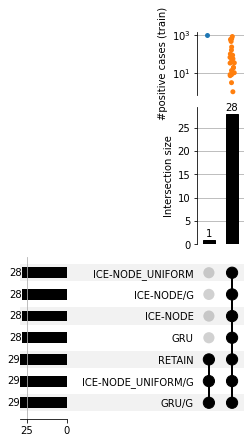

In [151]:
upset_clfs = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')

upsetcontents_m3, upsetindicator_m3, data_m3,  _, compete_codesm3 = relative_performance_upset(auctests_m3, 
                                                                                               upset_clfs, 
                                                                                               m3_interface[clfs[0]],
                                                                                               m3_train_ids,
                                                                                               **relative_auc_config)
upset_format = from_indicators(upsetindicator_m3, data=data_m3)
upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
# upset_object.add_catplot(value='Avg. AUC', kind="strip")
upset_object.add_catplot(value='#positive cases (train)', kind="strip")
g = upset_object.plot()
g['extra1'].set_yscale('log')

current_figure = plt.gcf()
current_figure.savefig(f"upset_M3.pdf")

In [150]:
compete_codesm3

CODE_INDEX  N_POSITIVE_CODES  AUC(GRU)  AUC(GRU/G)  AUC(ICE-NODE)  \
27          27               2.0     0.956       0.973          0.729   

    AUC(ICE-NODE/G)  AUC(ICE-NODE_UNIFORM)  AUC(ICE-NODE_UNIFORM/G)  \
27            0.836                  0.729                    0.858   

    AUC(RETAIN)  VAR[AUC(GRU)]  ...  P0(AUC_ICE-NODE==AUC_ICE-NODE_UNIFORM)  \
27        0.864      1.455e-04  ...                                     1.0   

    P0(AUC_ICE-NODE==AUC_ICE-NODE_UNIFORM/G)  P0(AUC_ICE-NODE==AUC_RETAIN)  \
27                                     0.002                         0.004   

    P0(AUC_ICE-NODE/G==AUC_ICE-NODE_UNIFORM)  \
27                                     0.005   

    P0(AUC_ICE-NODE/G==AUC_ICE-NODE_UNIFORM/G)  \
27                                   4.391e-06   

    P0(AUC_ICE-NODE/G==AUC_RETAIN)  \
27                           0.045   

    P0(AUC_ICE-NODE_UNIFORM==AUC_ICE-NODE_UNIFORM/G)  \
27                                             0.002   

    P0(AUC_ICE-NODE_UNIFORM==AUC_RETAIN)  \
27                                 0.004   

    P0(AUC_ICE-NODE_UNIFORM/G==AUC_RETAIN)       DESC  
27                                   0.615  Pneumonia  

[1 rows x 38 columns]

In [69]:
results_m3_k5, _ = evaluation_table(test_res_m3, m3_train_percentiles, top_k=5)
results_m3_k10, _ = evaluation_table(test_res_m3, m3_train_percentiles, top_k=10)
results_m3_k15, _ = evaluation_table(test_res_m3, m3_train_percentiles, top_k=15)


In [70]:

df_acc5 = results_m3_k5.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc5 = df_acc5.apply(lambda x: round(x, 3))
df_acc5.to_csv(f'acc5_mimic3.csv')
s_df, ltx_s = styled_df(df_acc5)
display(s_df)
print(ltx_s)


df_acc10 = results_m3_k10.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc10 = df_acc10.apply(lambda x: round(x, 3))
df_acc10.to_csv(f'acc10_mimic3.csv')
s_df, ltx_s = styled_df(df_acc10)
display(s_df)
print(ltx_s)


df_acc15 = results_m3_k15.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc15 = df_acc15.apply(lambda x: round(x, 3))
df_acc15.to_csv(f'acc15_mimic3.csv')
s_df, ltx_s = styled_df(df_acc15)
display(s_df)
print(ltx_s)

\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & 0.084 & 0.199 & 0.249 & 0.342 & \color{white} {\cellcolor{darkblue}} 0.647 \\
\texttt{ICE-NODE\_UNIFORM} & 0.084 & 0.199 & 0.249 & 0.342 & \color{white} {\cellcolor{darkblue}} 0.647 \\
\texttt{GRU} & 0.090 & 0.216 & 0.257 & \color{white} {\cellcolor{darkblue}} 0.361 & 0.575 \\
\texttt{RETAIN} & \color{white} {\cellcolor{darkblue}} 0.103 & \color{white} {\cellcolor{darkblue}} 0.226 & \color{white} {\cellcolor{darkblue}} 0.273 & 0.316 & 0.597 \\
\texttt{ICE-NODE/G} & 0.089 & 0.204 & 0.240 & 0.338 & 0.634 \\
\texttt{ICE-NODE\_UNIFORM/G} & 0.088 & 0.205 & 0.237 & 0.339 & 0.628 \\
\texttt{GRU/G} & 0.097 & 0.224 & 0.262 & 0.323 & 0.593 \\
\end{tabular}



\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & 0.130 & 0.320 & 0.434 & \color{white} {\cellcolor{darkblue}} 0.633 & \color{white} {\cellcolor{darkblue}} 0.843 \\
\texttt{ICE-NODE\_UNIFORM} & 0.130 & 0.320 & 0.434 & \color{white} {\cellcolor{darkblue}} 0.633 & \color{white} {\cellcolor{darkblue}} 0.843 \\
\texttt{GRU} & 0.137 & 0.313 & 0.433 & 0.625 & 0.816 \\
\texttt{RETAIN} & \color{white} {\cellcolor{darkblue}} 0.159 & \color{white} {\cellcolor{darkblue}} 0.331 & \color{white} {\cellcolor{darkblue}} 0.440 & 0.605 & 0.837 \\
\texttt{ICE-NODE/G} & 0.138 & 0.321 & 0.425 & 0.624 & 0.837 \\
\texttt{ICE-NODE\_UNIFORM/G} & 0.137 & 0.320 & 0.422 & 0.623 & 0.837 \\
\texttt{GRU/G} & 0.144 & 0.327 & 0.426 & 0.602 & 0.824 \\
\end{tabular}



\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & 0.175 & 0.407 & \color{white} {\cellcolor{darkblue}} 0.581 & 0.788 & 0.928 \\
\texttt{ICE-NODE\_UNIFORM} & 0.175 & 0.407 & \color{white} {\cellcolor{darkblue}} 0.581 & 0.788 & 0.928 \\
\texttt{GRU} & 0.178 & 0.401 & 0.564 & 0.786 & 0.924 \\
\texttt{RETAIN} & \color{white} {\cellcolor{darkblue}} 0.199 & \color{white} {\cellcolor{darkblue}} 0.417 & 0.575 & 0.778 & \color{white} {\cellcolor{darkblue}} 0.934 \\
\texttt{ICE-NODE/G} & 0.184 & 0.402 & 0.566 & \color{white} {\cellcolor{darkblue}} 0.791 & 0.919 \\
\texttt{ICE-NODE\_UNIFORM/G} & 0.181 & 0.404 & 0.568 & 0.788 & 0.919 \\
\texttt{GRU/G} & 0.185 & 0.402 & 0.561 & 0.771 & 0.919 \\
\end{tabular}



In [71]:
icenode_m3_excl = upsetcontents_m3['ICE-NODE'] - set.union(*list(upsetcontents_m3[clf] for clf in ('RETAIN', 'GRU')))
icenode_m3_excl = compete_codesm3[compete_codesm3['CODE_INDEX'].isin(icenode_m3_excl)]
icenode_m3_excl

Empty DataFrame
Columns: [CODE_INDEX, N_POSITIVE_CODES, AUC(GRU), AUC(GRU/G), AUC(ICE-NODE), AUC(ICE-NODE/G), AUC(ICE-NODE_UNIFORM), AUC(ICE-NODE_UNIFORM/G), AUC(RETAIN), VAR[AUC(GRU)], VAR[AUC(GRU/G)], VAR[AUC(ICE-NODE)], VAR[AUC(ICE-NODE/G)], VAR[AUC(ICE-NODE_UNIFORM)], VAR[AUC(ICE-NODE_UNIFORM/G)], VAR[AUC(RETAIN)], P0(AUC_GRU==AUC_GRU/G), P0(AUC_GRU==AUC_ICE-NODE), P0(AUC_GRU==AUC_ICE-NODE/G), P0(AUC_GRU==AUC_ICE-NODE_UNIFORM), P0(AUC_GRU==AUC_ICE-NODE_UNIFORM/G), P0(AUC_GRU==AUC_RETAIN), P0(AUC_GRU/G==AUC_ICE-NODE), P0(AUC_GRU/G==AUC_ICE-NODE/G), P0(AUC_GRU/G==AUC_ICE-NODE_UNIFORM), P0(AUC_GRU/G==AUC_ICE-NODE_UNIFORM/G), P0(AUC_GRU/G==AUC_RETAIN), P0(AUC_ICE-NODE==AUC_ICE-NODE/G), P0(AUC_ICE-NODE==AUC_ICE-NODE_UNIFORM), P0(AUC_ICE-NODE==AUC_ICE-NODE_UNIFORM/G), P0(AUC_ICE-NODE==AUC_RETAIN), P0(AUC_ICE-NODE/G==AUC_ICE-NODE_UNIFORM), P0(AUC_ICE-NODE/G==AUC_ICE-NODE_UNIFORM/G), P0(AUC_ICE-NODE/G==AUC_RETAIN), P0(AUC_ICE-NODE_UNIFORM==AUC_ICE-NODE_UNIFORM/G), P0(AUC_ICE-NODE_UNIFORM==AUC_RETAIN), P0(AUC_ICE-NODE_UNIFORM/G==AUC_RETAIN), DESC]
Index: []

[0 rows x 38 columns]

In [ ]:
ax = selected_auc_barplot(upset_clfs, icenode_m3_excl)
current_figure = plt.gcf()
current_figure.savefig("icenode_m3.pdf", bbox_inches='tight')
plt.show()


<a name="sec5"></a>

## 5 Relative AUC Performance on MIMIC-IV (Test Set) [^](#outline)

In [72]:
relauc_clfs =  ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')
m4_predictors = {clf: cross_predictor(clf, 'M4', 'M4') for clf in relauc_clfs}
test_res_m4 = {clf: eval2_(model, m4_test_ids) for clf, model in m4_predictors.items()} 

In [73]:
auctests_m4 = codes_auc_pairwise_tests({k: v['diag_detectability'] for k, v in test_res_m4.items()}, fast=True)


 46%|██████████████████▉                      | 112/242 [00:47<00:52,  2.45it/s]/home/asem/GP/ICENODE/analysis/../icenode/delong.py:203: RuntimeWarning: invalid value encountered in true_divide
  z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
100%|█████████████████████████████████████████| 242/242 [01:41<00:00,  2.38it/s]


237 codes predicted an AUC higher than 0.9 by at least one model.


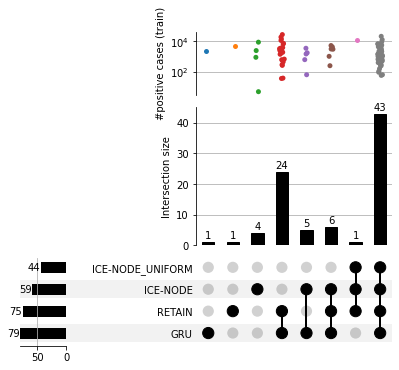

In [129]:
upset_clfs = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')

upsetcontents_m4, upsetindicator_m4, data_m4,  _, compete_codesm4 = relative_performance_upset(auctests_m4, 
                                                                                               upset_clfs, 
                                                                                               m4_interface[clfs[0]], 
                                                                                               m4_train_ids,
                                                                                               **relative_auc_config)
upset_format = from_indicators(upsetindicator_m4, data=data_m4)
upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
# upset_object.add_catplot(value='Avg. AUC', kind="strip")
upset_object.add_catplot(value='#positive cases (train)', kind="strip")

g = upset_object.plot()
g['extra1'].set_yscale('log')

current_figure = plt.gcf()
current_figure.savefig(f"upset_M4.pdf")

In [75]:
results_m4_k5, _ = evaluation_table(test_res_m4, m4_train_percentiles, top_k=5)
results_m4_k10, _ = evaluation_table(test_res_m4, m4_train_percentiles, top_k=10)
results_m4_k15, _ = evaluation_table(test_res_m4, m4_train_percentiles, top_k=15)

In [76]:

df_acc5 = results_m4_k5.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc5 = df_acc5.apply(lambda x: round(x, 3))
df_acc5.to_csv(f'acc5_mimic4.csv')
s_df, ltx_s = styled_df(df_acc5)
display(s_df)
print(ltx_s)


df_acc10 = results_m4_k10.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc10 = df_acc10.apply(lambda x: round(x, 3))
df_acc10.to_csv(f'acc10_mimic4.csv')
s_df, ltx_s = styled_df(df_acc10)
display(s_df)
print(ltx_s)


df_acc15 = results_m4_k15.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc15 = df_acc15.apply(lambda x: round(x, 3))
df_acc15.to_csv(f'acc15_mimic4.csv')
s_df, ltx_s = styled_df(df_acc15)
display(s_df)
print(ltx_s)

\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & \color{white} {\cellcolor{darkblue}} 0.224 & \color{white} {\cellcolor{darkblue}} 0.290 & 0.280 & 0.365 & 0.632 \\
\texttt{ICE-NODE\_UNIFORM} & 0.221 & 0.287 & 0.276 & 0.367 & 0.629 \\
\texttt{GRU} & 0.208 & 0.283 & \color{white} {\cellcolor{darkblue}} 0.302 & \color{white} {\cellcolor{darkblue}} 0.387 & \color{white} {\cellcolor{darkblue}} 0.642 \\
\texttt{RETAIN} & 0.218 & 0.284 & 0.297 & \color{white} {\cellcolor{darkblue}} 0.387 & 0.631 \\
\end{tabular}



\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & \color{white} {\cellcolor{darkblue}} 0.326 & \color{white} {\cellcolor{darkblue}} 0.420 & 0.474 & 0.617 & 0.833 \\
\texttt{ICE-NODE\_UNIFORM} & 0.320 & 0.415 & 0.469 & 0.611 & 0.832 \\
\texttt{GRU} & 0.300 & 0.411 & \color{white} {\cellcolor{darkblue}} 0.500 & \color{white} {\cellcolor{darkblue}} 0.652 & 0.849 \\
\texttt{RETAIN} & 0.308 & 0.404 & 0.493 & 0.651 & \color{white} {\cellcolor{darkblue}} 0.851 \\
\end{tabular}



\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & \color{white} {\cellcolor{darkblue}} 0.374 & \color{white} {\cellcolor{darkblue}} 0.493 & 0.599 & 0.778 & 0.904 \\
\texttt{ICE-NODE\_UNIFORM} & 0.370 & 0.485 & 0.593 & 0.773 & 0.906 \\
\texttt{GRU} & 0.355 & 0.491 & \color{white} {\cellcolor{darkblue}} 0.633 & 0.808 & 0.917 \\
\texttt{RETAIN} & 0.357 & 0.478 & 0.621 & \color{white} {\cellcolor{darkblue}} 0.815 & \color{white} {\cellcolor{darkblue}} 0.927 \\
\end{tabular}



In [77]:
icenode_m4_excl = upsetcontents_m4['ICE-NODE'] - set.union(*list(upsetcontents_m4[clf] for clf in ('RETAIN', 'GRU', 'ICE-NODE_UNIFORM')))
icenode_m4_excl = compete_codesm4[compete_codesm4['CODE_INDEX'].isin(icenode_m4_excl)]
icenode_m4_excl

CODE_INDEX  N_POSITIVE_CODES  AUC(GRU)  AUC(ICE-NODE)  \
6             6            2063.0     0.899          0.916   
94           94             129.0     0.959          0.968   
105         105            1040.0     0.981          0.985   
236         236            8394.0     0.888          0.912   

     AUC(ICE-NODE_UNIFORM)  AUC(RETAIN)  VAR[AUC(GRU)]  VAR[AUC(ICE-NODE)]  \
6                    0.891        0.899      1.418e-05           1.177e-05   
94                   0.959        0.961      4.874e-05           2.284e-05   
105                  0.978        0.980      1.920e-06           1.143e-06   
236                  0.885        0.889      4.589e-06           3.620e-06   

     VAR[AUC(ICE-NODE_UNIFORM)]  VAR[AUC(RETAIN)]  P0(AUC_GRU==AUC_ICE-NODE)  \
6                     1.602e-05         1.421e-05                  4.005e-10   
94                    3.719e-05         3.667e-05                  9.319e-03   
105                   2.186e-06         2.204e-06                  6.686e-07   
236                   5.062e-06         4.599e-06                  5.754e-48   

     P0(AUC_GRU==AUC_ICE-NODE_UNIFORM)  P0(AUC_GRU==AUC_RETAIN)  \
6                            1.883e-04                    0.635   
94                           9.462e-01                    0.558   
105                          1.467e-03                    0.086   
236                          1.745e-02                    0.302   

     P0(AUC_ICE-NODE==AUC_ICE-NODE_UNIFORM)  P0(AUC_ICE-NODE==AUC_RETAIN)  \
6                                 1.512e-24                     2.408e-09   
94                                1.402e-04                     7.551e-04   
105                               1.844e-11                     5.093e-09   
236                               1.964e-92                     1.746e-44   

     P0(AUC_ICE-NODE_UNIFORM==AUC_RETAIN)          DESC  
6                               5.494e-05  Pulm hart dx  
94                              2.906e-01   Early labor  
105                             8.168e-02   Forceps del  
236                             1.756e-03  Other ear dx

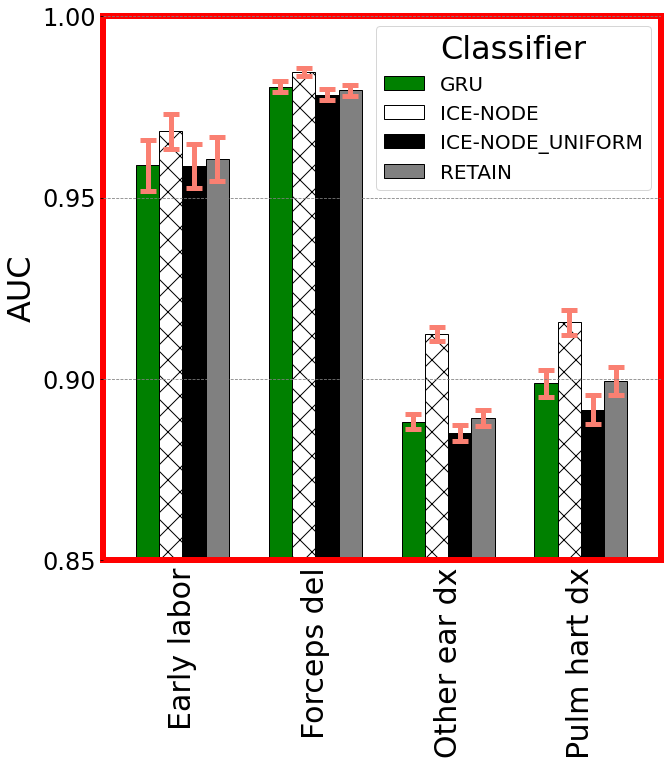

In [148]:
ax = selected_auc_barplot(upset_clfs, icenode_m4_excl, horizontal=False)
current_figure = plt.gcf()
current_figure.savefig("icenode_m4.pdf", bbox_inches='tight')
plt.show()


<a name="sec6"></a>

## 6 Relative AUC Performance From MIMIC-III (Training Set) to MIMIC-IV (All) [^](#outline)
 

In [ ]:
# clfs_ordered = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')
# m3_percentiles = m3_interface[clfs[0]].diag_flatccs_by_percentiles(20)

# m4_subjects = list(m4_interface[clfs[0]].subjects.keys())
# m3m4_predictors = {clf: cross_predictor(clf, 'M3', 'M4') for clf in clfs_ordered}


In [ ]:
# test_res_m3m4 = {clf: eval2_(model, m4_subjects) for clf, model in m3m4_predictors.items()} 
# results_m3m4, _ = evaluation_table(test_res_m3m4, m3_percentiles, top_k=20)


In [ ]:
# def test_eval_table(df, metric):
#     df = df.loc[metric, clfs_ordered]
#     return df.transpose()

# m3m4_acc20 = test_eval_table(results_m3m4, list(f'ACC-P{i}' for i in range(5)))
# m3m4_acc20.to_csv(f'm3m4_acc20.csv')
# print(m3m4_acc20.apply(lambda x: round(x, 3)).style.highlight_max(axis=0, props='bfseries: ;').to_latex())  

In [ ]:
# auctests_m3m4 = codes_auc_pairwise_tests({k: v['diag_detectability'] for k, v in test_res_m3m4.items()}, fast=True)


In [ ]:
# sets_m3m4, upsetm3m4_df, _, compete_codesm3m4 = relative_performance_upset(auctests_m3m4, upset_clfs, m4_interface[clfs[0]], **relative_auc_config)
# upset_contents_m3m4 = from_contents(sets_m3m4)


In [ ]:
# UpSet(upset_contents_m4m3, subset_size='count', show_counts=True).plot()
# current_figure = plt.gcf()
# current_figure.savefig(f"upset_contents_M4M3.pdf")


<a name="sec7"></a>

## 7 Relative AUC Performance From MIMIC-IV (Training Set) to MIMIC-III (All) [^](#outline)

In [78]:
clfs_ordered = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')
m3_subjects = list(m3_interface[clfs[0]].subjects.keys())
m4m3_predictors = {clf: cross_predictor(clf, 'M4', 'M3') for clf in clfs_ordered}

In [79]:
test_res_m4m3 = {clf: eval2_(model, m3_subjects) for clf, model in m4m3_predictors.items()} 

In [80]:
auctests_m4m3 = codes_auc_pairwise_tests({k: v['diag_detectability'] for k, v in test_res_m4m3.items()}, fast=True)

 37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                              | 90/242 [00:08<00:06, 22.92it/s]/home/asem/GP/ICENODE/analysis/../icenode/delong.py:203: RuntimeWarning: invalid value encountered in true_divide
  z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [00:22<

215 codes predicted an AUC higher than 0.9 by at least one model.


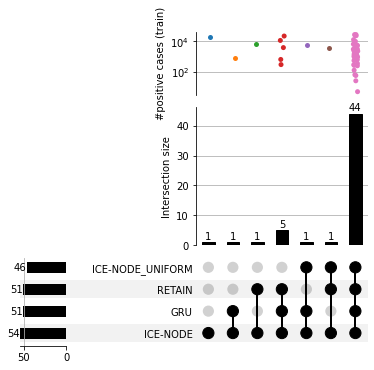

In [128]:
upset_clfs = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')
upsetcontents_m4m3, upsetindicator_m4m3, data_m4m3,  _, compete_codesm4m3 = relative_performance_upset(auctests_m4m3, 
                                                                                                       upset_clfs, 
                                                                                                       m4_interface[clfs[0]],
                                                                                                       m4_train_ids,
                                                                                                       **relative_auc_config)
upset_format = from_indicators(upsetindicator_m4m3, data=data_m4m3)
upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
# upset_object.add_catplot(value='Avg. AUC', kind="strip")
upset_object.add_catplot(value='#positive cases (train)', kind="strip")
g = upset_object.plot()
g['extra1'].set_yscale('log')

current_figure = plt.gcf()
current_figure.savefig(f"upset_M4M3.pdf")

In [82]:
results_m4m3_k5, _ = evaluation_table(test_res_m4m3, m4_train_percentiles, top_k=5)
results_m4m3_k10, _ = evaluation_table(test_res_m4m3, m4_train_percentiles, top_k=10)
results_m4m3_k15, _ = evaluation_table(test_res_m4m3, m4_train_percentiles, top_k=15)

In [83]:
df_acc5 = results_m4m3_k5.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc5 = df_acc5.apply(lambda x: round(x, 3))
df_acc5.to_csv(f'acc5_m4m3.csv')
s_df, ltx_s = styled_df(df_acc5)
display(s_df)
print(ltx_s)

df_acc10 = results_m4m3_k10.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc10 = df_acc10.apply(lambda x: round(x, 3))
df_acc10.to_csv(f'acc10_m4m3.csv')
s_df, ltx_s = styled_df(df_acc10)
display(s_df)
print(ltx_s)

df_acc15 = results_m4m3_k15.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc15 = df_acc15.apply(lambda x: round(x, 3))
df_acc15.to_csv(f'acc15_m4m3.csv')
s_df, ltx_s = styled_df(df_acc15)
display(s_df)
print(ltx_s)

\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & 0.214 & \color{white} {\cellcolor{darkblue}} 0.203 & 0.274 & 0.387 & 0.602 \\
\texttt{ICE-NODE\_UNIFORM} & 0.209 & 0.201 & 0.274 & 0.391 & 0.604 \\
\texttt{GRU} & 0.200 & 0.199 & \color{white} {\cellcolor{darkblue}} 0.296 & \color{white} {\cellcolor{darkblue}} 0.405 & \color{white} {\cellcolor{darkblue}} 0.609 \\
\texttt{RETAIN} & \color{white} {\cellcolor{darkblue}} 0.215 & \color{white} {\cellcolor{darkblue}} 0.203 & 0.292 & 0.404 & 0.579 \\
\end{tabular}



\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & \color{white} {\cellcolor{darkblue}} 0.311 & \color{white} {\cellcolor{darkblue}} 0.316 & 0.453 & 0.626 & 0.814 \\
\texttt{ICE-NODE\_UNIFORM} & 0.308 & 0.312 & 0.451 & 0.625 & 0.813 \\
\texttt{GRU} & 0.282 & 0.310 & \color{white} {\cellcolor{darkblue}} 0.475 & \color{white} {\cellcolor{darkblue}} 0.672 & \color{white} {\cellcolor{darkblue}} 0.818 \\
\texttt{RETAIN} & 0.298 & 0.309 & \color{white} {\cellcolor{darkblue}} 0.475 & 0.663 & 0.809 \\
\end{tabular}



\begin{tabular}{lrrrrr}
{} & {ACC-P0} & {ACC-P1} & {ACC-P2} & {ACC-P3} & {ACC-P4} \\
\texttt{ICE-NODE} & \color{white} {\cellcolor{darkblue}} 0.361 & 0.390 & 0.580 & 0.783 & 0.895 \\
\texttt{ICE-NODE\_UNIFORM} & 0.357 & 0.383 & 0.575 & 0.781 & 0.897 \\
\texttt{GRU} & 0.332 & \color{white} {\cellcolor{darkblue}} 0.392 & \color{white} {\cellcolor{darkblue}} 0.610 & \color{white} {\cellcolor{darkblue}} 0.819 & 0.896 \\
\texttt{RETAIN} & 0.345 & 0.384 & 0.602 & 0.813 & \color{white} {\cellcolor{darkblue}} 0.899 \\
\end{tabular}



In [84]:
icenode_m4m3_excl = upsetcontents_m4m3['ICE-NODE'] - set.union(*list(upsetcontents_m4m3[clf] for clf in ('RETAIN', 'GRU', 'ICE-NODE_UNIFORM')))
icenode_m4m3_excl = compete_codesm4m3[compete_codesm4m3['CODE_INDEX'].isin(icenode_m4m3_excl)]
icenode_m4m3_excl

CODE_INDEX  N_POSITIVE_CODES  AUC(GRU)  AUC(ICE-NODE)  \
64          64            1489.0     0.899          0.912   

    AUC(ICE-NODE_UNIFORM)  AUC(RETAIN)  VAR[AUC(GRU)]  VAR[AUC(ICE-NODE)]  \
64                  0.896        0.888      2.250e-05           1.812e-05   

    VAR[AUC(ICE-NODE_UNIFORM)]  VAR[AUC(RETAIN)]  P0(AUC_GRU==AUC_ICE-NODE)  \
64                   2.299e-05         2.590e-05                  2.598e-07   

    P0(AUC_GRU==AUC_ICE-NODE_UNIFORM)  P0(AUC_GRU==AUC_RETAIN)  \
64                              0.166                1.062e-08   

    P0(AUC_ICE-NODE==AUC_ICE-NODE_UNIFORM)  P0(AUC_ICE-NODE==AUC_RETAIN)  \
64                               6.857e-20                     2.773e-17   

    P0(AUC_ICE-NODE_UNIFORM==AUC_RETAIN)          DESC  
64                                 0.001  Ac renl fail

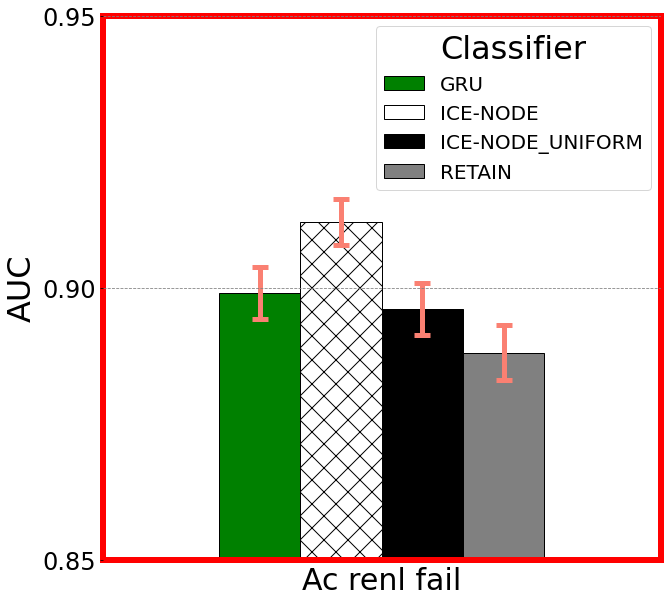

In [149]:
ax = selected_auc_barplot(upset_clfs, icenode_m4m3_excl, rotate_ccs=False)
current_figure = plt.gcf()
current_figure.savefig("icenode_m4m3.pdf", bbox_inches='tight')
plt.show()


## Trajectories for Patients with CCS codes best predicted with ICENODE

### Analyse AUC for Each Admission in the Test Partition

In [162]:
def admissions_auc_scores(model, test_ids):
    model, state = model
    return model.admissions_auc_scores(state, test_ids)

In [168]:
icenode_visit_auc_df = admissions_auc_scores(m4_predictors['ICE-NODE'], m4_test_ids)

In [169]:
icenode_visit_auc_df['N_VISITS'] = icenode_visit_auc_df['SUBJECT_ID'].apply(lambda i: (icenode_visit_auc_df['SUBJECT_ID'] == i).sum())

In [170]:
visit_auc_subject = icenode_visit_auc_df.groupby('SUBJECT_ID').agg({'AUC': 'mean', 'N_VISITS': 'max', 'N_CODES': ['min', 'max', 'mean', 'median'], 'INTERVALS': ['mean', 'max', 'min'], 'R/T': ['min', 'max', 'mean'] })


In [206]:
best_visit_auc_subjects =  visit_auc_subject[(visit_auc_subject.AUC['mean'] > 0.9) & (visit_auc_subject.N_VISITS['max'] > 4) & (visit_auc_subject.INTERVALS['max'] < 90)]


In [207]:
best_visit_auc_subjects

AUC N_VISITS N_CODES                      INTERVALS              \
             mean      max     min   max    mean median      mean   max   min   
SUBJECT_ID                                                                      
10018862    0.929        6    13.0  18.0  15.500   15.0    33.917  76.5  14.0   
10388675    0.976        7     8.0  19.0  11.000   10.0    26.500  71.0   5.0   
10831832    0.948        9     2.0   7.0   4.000    4.0    48.500  88.0  12.5   
11002268    0.912       10     3.0   8.0   5.900    6.0    12.750  22.0   5.0   
11027112    0.948        7     4.0  11.0   7.714    7.0    21.071  29.5   9.0   
11390714    0.947        5     3.0  12.0   5.800    4.0     8.100  12.0   3.0   
11494753    0.953       13     1.0  10.0   5.923    6.0    24.423  65.0   3.0   
11503871    0.949        6     3.0   8.0   6.167    6.5    18.417  27.5   7.0   
11593763    0.912        9    10.0  20.0  13.000   12.0    17.056  46.0   7.0   
12367864    0.954        7     5.0  19.0   8.286    6.0    22.500  31.5  13.0   
12668116    0.935        6     2.0   5.0   3.500    3.5    15.417  27.0   8.0   
12670020    0.962        7    10.0  15.0  11.857   11.0    38.500  66.0  15.0   
12709722    0.936        6     3.0   8.0   6.000    7.0    42.417  84.0   8.0   
12917869    0.933        6     7.0  12.0   9.500    9.5    21.250  81.0   7.0   
12917992    0.928        7     5.0  16.0  10.143   10.0    30.929  65.0   7.0   
13202932    0.909       12     2.0  16.0  10.000   10.5    30.708  77.0   9.0   
13218646    0.983        5     4.0   9.0   6.200    7.0    37.500  61.0  17.5   
13235049    0.929        6     3.0  22.0   9.000    7.0    20.250  38.0   5.0   
13443228    0.924        5     4.0   8.0   6.000    6.0    34.700  71.0  14.0   
13835105    0.987       16     2.0   6.0   3.938    4.0    21.531  70.0  14.0   
13965528    0.962        6     7.0  12.0   9.667   10.0    44.417  78.0   6.0   
14073676    0.954        7     3.0  11.0   6.429    6.0    12.500  19.0  10.0   
14541392    0.940        6    10.0  22.0  15.167   15.0    33.083  84.5   3.0   
14921998    0.938        5    11.0  21.0  13.600   12.0    46.300  83.0  16.0   
14937207    0.950        9     5.0  14.0  10.444   11.0    35.611  73.0   5.0   
15992037    0.917        5     9.0  14.0  12.000   12.0    21.300  46.5   3.0   
16274300    0.927       11     2.0   9.0   6.364    7.0    20.682  35.0   4.0   
16344680    0.950        6     6.0  12.0   9.167    9.0    20.250  39.0  11.0   
16445293    0.964        8     6.0  13.0   9.375    9.5    28.438  58.0   4.0   
16817269    0.959        8     6.0  10.0   7.500    7.0    26.938  69.0   8.0   
16881623    0.986        6     3.0   8.0   5.000    5.0    16.583  25.5   3.0   
17103939    0.979        6     5.0   8.0   6.333    6.5    19.083  31.5   9.0   
17205768    0.954       18     2.0  13.0   6.000    6.0    19.694  74.0   3.0   
17319133    0.960        9     3.0  10.0   5.667    5.0    16.944  55.0   3.0   
17422811    0.945        8     2.0   9.0   4.500    4.0    38.562  80.5  17.0   
17577670    0.939        5     7.0   9.0   8.200    8.0    21.700  56.0  11.0   
18303550    0.958        6     4.0   7.0   5.833    6.0    41.083  88.0   6.5   
18416473    0.933        5     6.0  14.0  10.000   10.0    38.700  79.0   8.0   
18439835    0.959       11    16.0  28.0  20.818   22.0    40.500  78.0  12.0   
18792281    0.947        6     5.0   9.0   6.833    6.0    29.083  63.0  20.0   
19380370    0.965        5     8.0  14.0   9.200    8.0    14.100  28.0   5.0   
19637670    0.907        5     8.0  20.0  11.800   10.0    39.500  76.5   3.0   

                       R/T                             
                       min             max       mean  
SUBJECT_ID                                             
10018862     4.4413932e-14   5.2810215e-11  1.628e-11  
10388675     1.2662594e-14   6.6784104e-12  2.320e-12  
10831832     1.4665947e-13    9.296178e-12  2.021e-12  
11002268     1.3988992e-14    1.

In [208]:
ccs_history = {i: m4_interface[clfs[0]].diag_flatccs_history(i)[1] for i in best_visit_auc_subjects.index}

In [209]:
ccs_history_ac_renal_fail = {i: history for i, history in ccs_history.items() if 64 in history}

In [210]:
len(ccs_history_ac_renal_fail)

19

In [211]:
icenode, icenode_state = m4_predictors['ICE-NODE']
trajectory = icenode.sample_trajectory(icenode_state, ccs_history_ac_renal_fail.keys(), 1)

  0%|                                                                                                                                                                                                                                                                                                                                                                                                    | 0/214 [00:00<?, ?it/s]/home/asem/GP/ICENODE/analysis/../icenode/train_icenode_tl.py:408: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pos[[top10_idx]] = 1
  6%|██████████████████████▉                                                                                                                                                                                                 

In [184]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [185]:
ccs_index = [64]
flatccs_idx2code = {idx: code for code, idx in m4_interface[clfs[0]].diag_flatccs_idx.items()}
idx2desc = lambda idx: m4_interface[clfs[0]].dag.diag_flatccs_desc[flatccs_idx2code[idx]]
ccs_description = list(map(idx2desc, ccs_index))


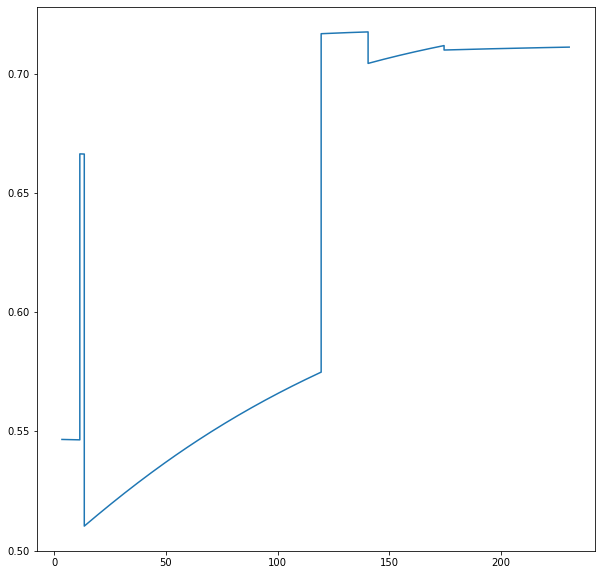

In [189]:
data = {}
for i, traj in trajectory.items():
    diag_times = m4_interface[clfs[0]].diag_times(i)
    
    t = traj['t']
    d = traj['d']
    
    prob = []
    time = []
    code = []
    
    for ccs_desc, ccs_idx in zip(ccs_description, ccs_index):
        plt.plot(t, d[:, ccs_idx])
    break
#         time.append(t)
#         code.extend([ccs_desc]*len(t))
#         prob.append(d[:, ccs_idx])

    
#     prob = np.hstack(prob)
#     time = np.hstack(time)
    
    
#     df = pd.DataFrame({'t': time, r'$\hat{v}$': prob, 'code': code})
#     data[i] = (df, diag_times)
    

In [ ]:
plt.rcParams['figure.figsize']=(10,10)
import math
for i, (df, diag_times) in data.items():

    plt.figure(i)
    
    g = sns.lineplot(data=df, x="t", y=r'$\hat{v}$', hue='code', marker='o')
    for diag_time in diag_times:
        g.axvline(x=diag_time, ymin=0, ymax=1, c="red", ls='--', linewidth=0.8, zorder=0, clip_on=False)

It seems that we cannot catch the smoothness of the trajectory as it evolves very quickly to the saturation value.